示例数据树结构：/Users/curiostudio/Desktop/geometry
├── group_best
│   ├── activation
│   │   └── longtail_50
│   │       ├── EleutherAI
│   │       │   ├── pythia-410m-deduped
│   │       │   │   └── prob
│   │       │   │       ├── 500_10.debug
│   │       │   │       ├── 500_10.json
│   │       │   │       ├── 500_100.json
│   │       │   │       └── 500_50.json
│   │       │   └── pythia-70m-deduped
│   │       │       └── prob
│   │       │           ├── 500_10.debug
│   │       │           ├── 500_10.json
│   │       │           ├── 500_100.json
│   │       │           └── 500_50.json
│   │       └── prob
│   └── weight
...
├── group_target_size
│   ├── activation
│   │   └── longtail_50
...
└── individual


In [29]:
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
ROOT_dir = Path('/Users/jliu/workspace/RAG')

## delt loss inspection

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path

def find_transition_point(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 50,
    threshold_multiplier: float = 2.0,
    min_rank_percentile: float = 0.05,
    max_rank_percentile: float = 1.0,
    expected_direction: str = "any",  # "positive", "negative", or "any"
    min_log_rank: float = None,
    max_log_rank: float = None,
) -> dict:
    """
    Find a transition point using second derivative analysis with constraints.
    
    Parameters:
    -----------
    log_ranks: log-rank values
    log_vals: log-value data points
    window_size: window for calculating local slopes
    threshold_multiplier: sensitivity for detecting significant changes
    min_rank_percentile: minimum percentile to start analysis
    max_rank_percentile: maximum percentile to end analysis
    expected_direction: expected direction of second derivative ("positive", "negative", or "any")
    min_log_rank: minimum log rank to consider (direct constraint)
    max_log_rank: maximum log rank to consider (direct constraint)
    
    Returns:
    --------
    Dictionary with transition point information
    """
    n = len(log_ranks)
    info = {"transition_detected": False}
    
    # Apply rank percentile constraints
    min_idx = max(int(n * min_rank_percentile), window_size)
    max_idx = min(int(n * max_rank_percentile), n - window_size)
    
    # Apply direct log rank constraints if provided
    if min_log_rank is not None:
        min_rank_idx = np.where(log_ranks >= min_log_rank)[0]
        if len(min_rank_idx) > 0:
            min_idx = max(min_idx, min_rank_idx[0])
    
    if max_log_rank is not None:
        max_rank_idx = np.where(log_ranks <= max_log_rank)[0]
        if len(max_rank_idx) > 0:
            max_idx = min(max_idx, max_rank_idx[-1])
    
    # Ensure we have enough data points
    if max_idx <= min_idx + window_size:
        return info
    
    # Dynamic window size
    w = min(window_size, max(5, (max_idx - min_idx) // 5))
    
    # Calculate first derivatives (slopes)
    derivatives, idxs = [], []
    for i in range(min_idx, max_idx - w + 1):
        slope, _, _, _, _ = stats.linregress(
            log_ranks[i : i + w], log_vals[i : i + w]
        )
        derivatives.append(slope)
        idxs.append(i)
    
    derivatives = np.array(derivatives)
    
    # Calculate second derivatives (changes in slope)
    if len(derivatives) > 1:
        second_derivatives = np.diff(derivatives)
        
        # Apply direction constraint if specified
        if expected_direction == "positive":
            second_derivatives[second_derivatives <= 0] = 0
        elif expected_direction == "negative":
            second_derivatives[second_derivatives >= 0] = 0
        
        # Find significant changes
        abs_second_derivatives = np.abs(second_derivatives)
        threshold = np.mean(abs_second_derivatives) * threshold_multiplier
        significant_changes = np.where(abs_second_derivatives > threshold)[0]
        
        if len(significant_changes) > 0:
            # Find the most significant change
            max_change_idx = significant_changes[np.argmax(abs_second_derivatives[significant_changes])]
            transition_idx = idxs[max_change_idx + 1]  # +1 because of diff
            
            return {
                "transition_detected": True,
                "method": "second_derivative",
                "index": transition_idx,
                "log_rank": log_ranks[transition_idx],
                "log_value": log_vals[transition_idx],
                "second_derivative": second_derivatives[max_change_idx],
                "significance": abs_second_derivatives[max_change_idx] / threshold
            }
    
    return info

def zipf_and_transitions(values, **kwargs):
    """Analyze the distribution and identify both transition points using a unified approach."""
    arr = np.array(values)
    arr = arr[arr > 0]
    sorted_vals = np.sort(arr)[::-1]
    ranks = np.arange(1, len(sorted_vals)+1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # Fit the overall linear model (Zipf)
    coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    zipf_slope = coeffs[0]
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    # Extract parameters for plateau transition
    plateau_params = {
        "window_size": kwargs.get("plateau_window_size", 3),
        "threshold_multiplier": kwargs.get("plateau_threshold_multiplier", 0.3),
        "min_rank_percentile": kwargs.get("plateau_min_rank_percentile", 0.0),
        "max_rank_percentile": kwargs.get("plateau_max_rank_percentile", 3.0),
        "expected_direction": "positive",  # Slope becomes more negative (second derivative positive)
        "max_log_rank": kwargs.get("plateau_max_log_rank", 3.0)  # Force early detection
    }
    
    # Extract parameters for elbow point
    elbow_params = {
        "window_size": kwargs.get("elbow_window_size", 20),
        "threshold_multiplier": kwargs.get("elbow_threshold_multiplier", 2.0),
        "min_rank_percentile": kwargs.get("elbow_min_rank_percentile", 0.4),
        "max_rank_percentile": kwargs.get("elbow_max_rank_percentile", 0.85),
        "expected_direction": "negative",  # Slope becomes even more negative (second derivative negative)
        "min_log_rank": kwargs.get("elbow_min_log_rank", None)
    }
    
    # Find the plateau transition
    plateau_info = find_transition_point(log_ranks, log_vals, **plateau_params)
    
    # Rename for clarity
    if plateau_info["transition_detected"]:
        plateau_info["plateau_detected"] = plateau_info.pop("transition_detected")
    else:
        plateau_info["plateau_detected"] = False
    
    # Find the elbow point
    elbow_info = find_transition_point(log_ranks, log_vals, **elbow_params)
    
    # Rename for clarity
    if elbow_info["transition_detected"]:
        elbow_info["elbow_detected"] = elbow_info.pop("transition_detected")
    else:
        elbow_info["elbow_detected"] = False
    
    # Ensure elbow comes after plateau if both are detected
    if (plateau_info["plateau_detected"] and elbow_info["elbow_detected"] and 
        plateau_info["index"] >= elbow_info["index"]):
        # Constrain elbow search to be after plateau
        elbow_params["min_rank_percentile"] = plateau_info["index"] / len(log_ranks) + 0.05
        elbow_info = find_transition_point(log_ranks, log_vals, **elbow_params)
        
        if elbow_info["transition_detected"]:
            elbow_info["elbow_detected"] = elbow_info.pop("transition_detected")
        else:
            elbow_info["elbow_detected"] = False
    
    return log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info

def calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info):
    """Calculate metrics for each phase."""
    metrics = {}
    
    if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
        # Get the indices for each phase boundary
        plateau_idx = plateau_info["index"]
        elbow_idx = elbow_info["index"]
        
        # Define the three phases
        plateau_mask = np.arange(len(log_ranks)) < plateau_idx
        linear_mask = (np.arange(len(log_ranks)) >= plateau_idx) & (np.arange(len(log_ranks)) < elbow_idx)
        fast_decay_mask = np.arange(len(log_ranks)) >= elbow_idx
        
        # Calculate metrics for each phase
        
        # 1. Phase sizes (number of neurons)
        metrics["plateau_size"] = np.sum(plateau_mask)
        metrics["linear_size"] = np.sum(linear_mask)
        metrics["fast_decay_size"] = np.sum(fast_decay_mask)
        
        # 2. Phase percentages
        total = len(log_ranks)
        metrics["plateau_percent"] = 100 * metrics["plateau_size"] / total
        metrics["linear_percent"] = 100 * metrics["linear_size"] / total
        metrics["fast_decay_percent"] = 100 * metrics["fast_decay_size"] / total
        
        # 3. Area metrics (deviation from linear fit)
        # Area above linear for plateau phase
        if np.any(plateau_mask):
            metrics["plateau_area"] = np.sum(log_vals[plateau_mask] - zipf_line[plateau_mask])
        else:
            metrics["plateau_area"] = 0
            
        # Area below linear for fast decay phase
        if np.any(fast_decay_mask):
            metrics["fast_decay_area"] = np.sum(zipf_line[fast_decay_mask] - log_vals[fast_decay_mask])
        else:
            metrics["fast_decay_area"] = 0
        
        # 4. Average slopes in each phase
        if np.sum(plateau_mask) >= 2:
            plateau_slope, _, _, _, _ = stats.linregress(
                log_ranks[plateau_mask], log_vals[plateau_mask]
            )
            metrics["plateau_slope"] = plateau_slope
        else:
            metrics["plateau_slope"] = None
            
        if np.sum(linear_mask) >= 2:
            linear_slope, _, _, _, _ = stats.linregress(
                log_ranks[linear_mask], log_vals[linear_mask]
            )
            metrics["linear_slope"] = linear_slope
        else:
            metrics["linear_slope"] = None
            
        if np.sum(fast_decay_mask) >= 2:
            fast_decay_slope, _, _, _, _ = stats.linregress(
                log_ranks[fast_decay_mask], log_vals[fast_decay_mask]
            )
            metrics["fast_decay_slope"] = fast_decay_slope
        else:
            metrics["fast_decay_slope"] = None
        
        # 5. Second derivative magnitudes at transition points
        if "second_derivative" in plateau_info:
            metrics["plateau_transition_magnitude"] = plateau_info["second_derivative"]
            metrics["plateau_transition_significance"] = plateau_info.get("significance", 0)
            
        if "second_derivative" in elbow_info:
            metrics["elbow_transition_magnitude"] = elbow_info["second_derivative"]
            metrics["elbow_transition_significance"] = elbow_info.get("significance", 0)
    
    return metrics

def plot_zipf_elbow(
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info, 
    title: str, save_path: Path
):
    """Create visualization with all three phases identified and metrics displayed."""
    plt.figure(figsize=(6, 4))
    plt.plot(log_ranks, log_vals, '.', alpha=0.6, label='Original Data')
    plt.plot(log_ranks, zipf_line, 'r-', linewidth=1.5,
             label=f'Zipf Fit Slope={coeffs[0]:.2f}')
    
    # Initialize text box
    box_text = [f"Slope fit: {coeffs[0]:.2f}"]
    
    # Calculate phase metrics if both transitions detected
    if elbow_info.get("elbow_detected") and plateau_info.get("plateau_detected"):
        metrics = calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info)
        
        # Add shaded regions for the three phases
        plt.axvspan(min(log_ranks), plateau_info["log_rank"], alpha=0.1, color='blue', 
                    label='High-Rank Plateau')
        plt.axvspan(plateau_info["log_rank"], elbow_info["log_rank"], alpha=0.1, color='green', 
                    label='Mid-Rank Linear')
        plt.axvspan(elbow_info["log_rank"], max(log_ranks), alpha=0.1, color='red', 
                    label='Low-Rank Fast Decay')
        
        # Add key metrics to text box
        if "plateau_area" in metrics:
            box_text.append(f"Plateau area: {metrics['plateau_area']:.2f}")
        if "plateau_transition_significance" in metrics:
            box_text.append(f"Plateau significance: {metrics['plateau_transition_significance']:.2f}")
        if "fast_decay_area" in metrics:
            box_text.append(f"Fast decay area: {metrics['fast_decay_area']:.2f}")
        if "elbow_transition_significance" in metrics:
            box_text.append(f"Elbow significance: {metrics['elbow_transition_significance']:.2f}")
    
    # Mark the plateau transition
    if plateau_info.get("plateau_detected"):
        lr_plateau = plateau_info["log_rank"]
        lv_plateau = plateau_info["log_value"]
        idx_plateau = plateau_info["index"]
        mtd_plateau = plateau_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_plateau, lv_plateau, c='blue', marker='D', s=100, 
                   label='Plateau Transition')
        plt.vlines(lr_plateau, ymin=min(log_vals)*0.95, ymax=lv_plateau,
                 colors='blue', linestyles='--')
        
        box_text.append(f"Plateau@rank={idx_plateau}")
    else:
        box_text.append("!NO Plateau Detected")
    
    # Mark the elbow point
    if elbow_info.get("elbow_detected"):
        lr_elbow = elbow_info["log_rank"]
        lv_elbow = elbow_info["log_value"]
        idx_elbow = elbow_info["index"]
        mtd_elbow = elbow_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_elbow, lv_elbow, c='green', marker='X', s=100, label='Elbow Point')
        plt.vlines(lr_elbow, ymin=min(log_vals)*0.95, ymax=lv_elbow,
                 colors='green', linestyles='--')
        
        box_text.append(f"Elbow@rank={idx_elbow}")
    else:
        box_text.append("!NO Elbow Point")
    
    # Add text box with metrics in upper right corner
    plt.gca().text(
        0.95, 0.95, "\n".join(box_text),
        transform=plt.gca().transAxes,
        fontsize=9, va='top', ha='right',
        bbox=dict(boxstyle="round,pad=0.3", fc="wheat", ec="gray", lw=0.8)
    )
    
    plt.title(title)
    plt.xlabel("Log Rank")
    plt.ylabel("Log Value")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)



def run_analysis(root_dir: str, output_dir: str, save_metrics: bool = True):
    """
    Batch process all 500_all.csv files in the directory,
    perform Zipf analysis with unified second-derivative transition detection,
    and save results to output_dir.
    
    Parameters:
    -----------
    root_dir: Directory containing CSV files with neuron influence data
    output_dir: Directory to save plots and metrics
    save_metrics: Whether to save phase metrics to JSON files
    """
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create a metrics directory if saving metrics
    if save_metrics:
        metrics_path = output_path / "metrics"
        metrics_path.mkdir(exist_ok=True)
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    
    # Track metrics across all files for summary analysis
    all_metrics = []
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        
        # Dictionary to store metrics for this file
        file_metrics = {"file_id": rel_id, "steps": []}
        
        # Analyze each training step
        for _, row in df.iterrows():
            step = row["step"]
            vals = row["abs_delta_loss_post_ablation"]
            
            # Apply the new unified approach
            lr, lv, zl, coeffs, elbow_info, plateau_info = zipf_and_transitions(
                vals,
                # Plateau transition parameters
                plateau_window_size=3,
                plateau_threshold_multiplier=1.5,
                plateau_min_rank_percentile=0.005,
                plateau_max_log_rank=3.0,
                
                # Elbow point parameters
                elbow_window_size=10,
                elbow_threshold_multiplier=1.8,
                elbow_min_rank_percentile=0.2
            )
            
            # Generate and save the plot
            title = f"[{rel_id}] Step {step} Zipf+Transitions"
            save_p = output_path / f"{rel_id}_step{step}_zipf_transitions.png"
            plot_zipf_elbow(lr, lv, zl, coeffs, elbow_info, plateau_info, title, save_p)
            
            # Calculate and store metrics if both transitions are detected
            if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
                metrics = calculate_phase_metrics(lr, lv, zl, plateau_info, elbow_info)
                
                # Add step information
                step_metrics = {
                    "step": step,
                    "zipf_slope": coeffs[0],
                    "plateau_rank": int(plateau_info["index"]),
                    "plateau_log_rank": float(plateau_info["log_rank"]),
                    "elbow_rank": int(elbow_info["index"]),
                    "elbow_log_rank": float(elbow_info["log_rank"]),
                    **metrics
                }
                
                # Add to file metrics
                file_metrics["steps"].append(step_metrics)
                
                # Add to all metrics with file identifier
                all_metrics.append({
                    "file_id": rel_id,
                    "step": step,
                    **step_metrics
                })
        
        # Save metrics for this file if requested
        if save_metrics and file_metrics["steps"]:
            metrics_file = metrics_path / f"{rel_id}_metrics.json"
            with open(metrics_file, 'w') as f:
                json.dump(file_metrics, f, indent=2)
    
    # Create a summary plot of transitions across training steps if we have enough data
    if len(all_metrics) > 1:
        create_transition_summary(all_metrics, output_path)
    
    plt.close('all')  # Close any remaining plots

def create_transition_summary(metrics_list, output_path):
    """Create summary visualizations of phase transitions across training steps."""
    # Convert to DataFrame for easier analysis
    metrics_df = pd.DataFrame(metrics_list)
    
    # Group by file_id to analyze each model separately
    for file_id, group in metrics_df.groupby('file_id'):
        if len(group) < 2:  # Skip if not enough data points
            continue
        
        # Sort by step for proper ordering
        group = group.sort_values('step')
        steps = group['step'].astype(int).values
        
        # Create figure with multiple subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: Transition ranks over training steps
        axs[0, 0].plot(steps, group['plateau_rank'], 'b-o', label='Plateau Transition')
        axs[0, 0].plot(steps, group['elbow_rank'], 'g-x', label='Elbow Point')
        axs[0, 0].set_xlabel('Training Step')
        axs[0, 0].set_ylabel('Rank')
        axs[0, 0].set_title('Transition Points by Rank')
        axs[0, 0].legend()
        
        # Plot 2: Phase sizes as percentages
        axs[0, 1].stackplot(steps, 
                           group['plateau_percent'].values,
                           group['linear_percent'].values, 
                           group['fast_decay_percent'].values,
                           labels=['Plateau', 'Linear', 'Fast Decay'],
                           colors=['blue', 'green', 'red'], alpha=0.7)
        axs[0, 1].set_xlabel('Training Step')
        axs[0, 1].set_ylabel('Percentage')
        axs[0, 1].set_title('Phase Size Distribution')
        axs[0, 1].legend()
        
        # Plot 3: Area metrics over training steps
        axs[1, 0].plot(steps, group['plateau_area'], 'b-o', label='Plateau Area')
        axs[1, 0].plot(steps, group['fast_decay_area'], 'r-x', label='Fast Decay Area')
        axs[1, 0].set_xlabel('Training Step')
        axs[1, 0].set_ylabel('Area')
        axs[1, 0].set_title('Phase Deviation Areas')
        axs[1, 0].legend()
        
        # Plot 4: Slopes within each phase
        if 'plateau_slope' in group.columns and 'linear_slope' in group.columns and 'fast_decay_slope' in group.columns:
            # Convert any None values to NaN for plotting
            plateau_slopes = pd.Series(group['plateau_slope'].values).replace({None: np.nan})
            linear_slopes = pd.Series(group['linear_slope'].values).replace({None: np.nan})
            fast_decay_slopes = pd.Series(group['fast_decay_slope'].values).replace({None: np.nan})
            
            axs[1, 1].plot(steps, plateau_slopes, 'b-o', label='Plateau Slope')
            axs[1, 1].plot(steps, linear_slopes, 'g-s', label='Linear Slope')
            axs[1, 1].plot(steps, fast_decay_slopes, 'r-x', label='Fast Decay Slope')
            axs[1, 1].set_xlabel('Training Step')
            axs[1, 1].set_ylabel('Slope')
            axs[1, 1].set_title('Phase Slopes')
            axs[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig(output_path / f"{file_id}_phase_transitions_summary.png", dpi=300)
        plt.close()



In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import ast
import json

def find_transition_point(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 50,
    threshold_multiplier: float = 2.0,
    min_rank_percentile: float = 0.05,
    max_rank_percentile: float = 1.0,
    expected_direction: str = "any",  # "positive", "negative", or "any"
    min_log_rank: float = None,
    max_log_rank: float = None,
) -> dict:
    """
    Find a transition point using second derivative analysis with constraints.
    
    Parameters:
    -----------
    log_ranks: log-rank values
    log_vals: log-value data points
    window_size: window for calculating local slopes
    threshold_multiplier: sensitivity for detecting significant changes
    min_rank_percentile: minimum percentile to start analysis
    max_rank_percentile: maximum percentile to end analysis
    expected_direction: expected direction of second derivative ("positive", "negative", or "any")
    min_log_rank: minimum log rank to consider (direct constraint)
    max_log_rank: maximum log rank to consider (direct constraint)
    
    Returns:
    --------
    Dictionary with transition point information
    """
    n = len(log_ranks)
    info = {"transition_detected": False}
    
    # Apply rank percentile constraints
    min_idx = max(int(n * min_rank_percentile), window_size)
    max_idx = min(int(n * max_rank_percentile), n - window_size)
    
    # Apply direct log rank constraints if provided
    if min_log_rank is not None:
        min_rank_idx = np.where(log_ranks >= min_log_rank)[0]
        if len(min_rank_idx) > 0:
            min_idx = max(min_idx, min_rank_idx[0])
    
    if max_log_rank is not None:
        max_rank_idx = np.where(log_ranks <= max_log_rank)[0]
        if len(max_rank_idx) > 0:
            max_idx = min(max_idx, max_rank_idx[-1])
    
    # Ensure we have enough data points
    if max_idx <= min_idx + window_size:
        return info
    
    # Dynamic window size
    w = min(window_size, max(5, (max_idx - min_idx) // 5))
    
    # Calculate first derivatives (slopes)
    derivatives, idxs = [], []
    for i in range(min_idx, max_idx - w + 1):
        slope, _, _, _, _ = stats.linregress(
            log_ranks[i : i + w], log_vals[i : i + w]
        )
        derivatives.append(slope)
        idxs.append(i)
    
    derivatives = np.array(derivatives)
    
    # Calculate second derivatives (changes in slope)
    if len(derivatives) > 1:
        second_derivatives = np.diff(derivatives)
        
        # Apply direction constraint if specified
        if expected_direction == "positive":
            second_derivatives[second_derivatives <= 0] = 0
        elif expected_direction == "negative":
            second_derivatives[second_derivatives >= 0] = 0
        
        # Find significant changes
        abs_second_derivatives = np.abs(second_derivatives)
        threshold = np.mean(abs_second_derivatives) * threshold_multiplier
        significant_changes = np.where(abs_second_derivatives > threshold)[0]
        
        if len(significant_changes) > 0:
            # Find the most significant change
            max_change_idx = significant_changes[np.argmax(abs_second_derivatives[significant_changes])]
            transition_idx = idxs[max_change_idx + 1]  # +1 because of diff
            
            return {
                "transition_detected": True,
                "method": "second_derivative",
                "index": transition_idx,
                "log_rank": log_ranks[transition_idx],
                "log_value": log_vals[transition_idx],
                "second_derivative": second_derivatives[max_change_idx],
                "significance": abs_second_derivatives[max_change_idx] / threshold
            }
    
    return info

def zipf_and_transitions(values, plateau_params=None, elbow_params=None):
    """
    Analyze the distribution and identify both transition points using a unified approach.
    
    Parameters:
    -----------
    values: Neuron influence values
    plateau_params: Dictionary of parameters for plateau transition detection
    elbow_params: Dictionary of parameters for elbow point detection
    
    Returns:
    --------
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info
    """
    arr = np.array(values)
    arr = arr[arr > 0]
    sorted_vals = np.sort(arr)[::-1]
    ranks = np.arange(1, len(sorted_vals)+1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # Fit the overall linear model (Zipf)
    coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    zipf_slope = coeffs[0]
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    # Default parameters for plateau transition
    default_plateau_params = {
        "window_size": 3,
        "threshold_multiplier": 0.3,
        "min_rank_percentile": 0.0,
        "max_rank_percentile": 0.3,
        "expected_direction": "positive",  # Slope becomes more negative (second derivative positive)
        "max_log_rank": 3.0  # Force early detection
    }
    
    # Default parameters for elbow point
    default_elbow_params = {
        "window_size": 20,
        "threshold_multiplier": 2.0,
        "min_rank_percentile": 0.4,
        "max_rank_percentile": 0.85,
        "expected_direction": "negative",  # Slope becomes even more negative (second derivative negative)
        "min_log_rank": 5.5,
        "max_log_rank": 6.5
    }
    
    # Update with provided parameters if any
    if plateau_params is not None:
        default_plateau_params.update(plateau_params)
    
    if elbow_params is not None:
        default_elbow_params.update(elbow_params)
    
    # Find the plateau transition
    plateau_info = find_transition_point(log_ranks, log_vals, **default_plateau_params)
    
    # Rename for clarity
    if plateau_info["transition_detected"]:
        plateau_info["plateau_detected"] = plateau_info.pop("transition_detected")
    else:
        plateau_info["plateau_detected"] = False
    
    # Find the elbow point
    elbow_info = find_transition_point(log_ranks, log_vals, **default_elbow_params)
    
    # Rename for clarity
    if elbow_info["transition_detected"]:
        elbow_info["elbow_detected"] = elbow_info.pop("transition_detected")
    else:
        elbow_info["elbow_detected"] = False
    
    # Ensure elbow comes after plateau if both are detected
    if (plateau_info["plateau_detected"] and elbow_info["elbow_detected"] and 
        plateau_info["index"] >= elbow_info["index"]):
        # Constrain elbow search to be after plateau
        default_elbow_params["min_rank_percentile"] = plateau_info["index"] / len(log_ranks) + 0.05
        elbow_info = find_transition_point(log_ranks, log_vals, **default_elbow_params)
        
        if elbow_info["transition_detected"]:
            elbow_info["elbow_detected"] = elbow_info.pop("transition_detected")
        else:
            elbow_info["elbow_detected"] = False
    
    return log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info

def calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info):
    """Calculate metrics for each phase."""
    metrics = {}
    
    if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
        # Get the indices for each phase boundary
        plateau_idx = plateau_info["index"]
        elbow_idx = elbow_info["index"]
        
        # Define the three phases
        plateau_mask = np.arange(len(log_ranks)) < plateau_idx
        linear_mask = (np.arange(len(log_ranks)) >= plateau_idx) & (np.arange(len(log_ranks)) < elbow_idx)
        fast_decay_mask = np.arange(len(log_ranks)) >= elbow_idx
        
        # Calculate metrics for each phase
        
        # 1. Phase sizes (number of neurons)
        metrics["plateau_size"] = np.sum(plateau_mask)
        metrics["linear_size"] = np.sum(linear_mask)
        metrics["fast_decay_size"] = np.sum(fast_decay_mask)
        
        # 2. Phase percentages
        total = len(log_ranks)
        metrics["plateau_percent"] = 100 * metrics["plateau_size"] / total
        metrics["linear_percent"] = 100 * metrics["linear_size"] / total
        metrics["fast_decay_percent"] = 100 * metrics["fast_decay_size"] / total
        
        # 3. Area metrics (deviation from linear fit)
        # Area above linear for plateau phase
        if np.any(plateau_mask):
            metrics["plateau_area"] = np.sum(log_vals[plateau_mask] - zipf_line[plateau_mask])
        else:
            metrics["plateau_area"] = 0
            
        # Area below linear for fast decay phase
        if np.any(fast_decay_mask):
            metrics["fast_decay_area"] = np.sum(zipf_line[fast_decay_mask] - log_vals[fast_decay_mask])
        else:
            metrics["fast_decay_area"] = 0
        
        # 4. Average slopes in each phase
        if np.sum(plateau_mask) >= 2:
            plateau_slope, _, _, _, _ = stats.linregress(
                log_ranks[plateau_mask], log_vals[plateau_mask]
            )
            metrics["plateau_slope"] = plateau_slope
        else:
            metrics["plateau_slope"] = None
            
        if np.sum(linear_mask) >= 2:
            linear_slope, _, _, _, _ = stats.linregress(
                log_ranks[linear_mask], log_vals[linear_mask]
            )
            metrics["linear_slope"] = linear_slope
        else:
            metrics["linear_slope"] = None
            
        if np.sum(fast_decay_mask) >= 2:
            fast_decay_slope, _, _, _, _ = stats.linregress(
                log_ranks[fast_decay_mask], log_vals[fast_decay_mask]
            )
            metrics["fast_decay_slope"] = fast_decay_slope
        else:
            metrics["fast_decay_slope"] = None
        
        # 5. Second derivative magnitudes at transition points
        if "second_derivative" in plateau_info:
            metrics["plateau_transition_magnitude"] = plateau_info["second_derivative"]
            metrics["plateau_transition_significance"] = plateau_info.get("significance", 0)
            
        if "second_derivative" in elbow_info:
            metrics["elbow_transition_magnitude"] = elbow_info["second_derivative"]
            metrics["elbow_transition_significance"] = elbow_info.get("significance", 0)
    
    return metrics

def plot_zipf_elbow(
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info, 
    title: str, save_path: Path, ylim: tuple = None
):
    """
    Create visualization with all three phases identified and metrics displayed.
    
    Parameters:
    -----------
    log_ranks: Log-rank values
    log_vals: Log-value data points
    zipf_line: Fitted Zipf line
    coeffs: Fit coefficients
    elbow_info: Elbow point detection results
    plateau_info: Plateau transition detection results
    title: Plot title
    save_path: Path to save the figure
    ylim: Y-axis limits (min, max) to unify plots
    """
    plt.figure(figsize=(6, 4))
    plt.plot(log_ranks, log_vals, '.', alpha=0.6, label='Original Data')
    plt.plot(log_ranks, zipf_line, 'r-', linewidth=1.5,
             label=f'Zipf Fit Slope={coeffs[0]:.2f}')
    
    # Initialize text box
    box_text = [f"Slope fit: {coeffs[0]:.2f}"]
    
    # Calculate phase metrics if both transitions detected
    if elbow_info.get("elbow_detected") and plateau_info.get("plateau_detected"):
        metrics = calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info)
        
        # Add shaded regions for the three phases
        plt.axvspan(min(log_ranks), plateau_info["log_rank"], alpha=0.1, color='blue', 
                    label='High-Rank Plateau')
        plt.axvspan(plateau_info["log_rank"], elbow_info["log_rank"], alpha=0.1, color='green', 
                    label='Mid-Rank Linear')
        plt.axvspan(elbow_info["log_rank"], max(log_ranks), alpha=0.1, color='red', 
                    label='Low-Rank Fast Decay')
        
        # Add key metrics to text box
        if "plateau_area" in metrics:
            box_text.append(f"Plateau area: {metrics['plateau_area']:.2f}")
        if "plateau_transition_significance" in metrics:
            box_text.append(f"Plateau significance: {metrics['plateau_transition_significance']:.2f}")
        if "fast_decay_area" in metrics:
            box_text.append(f"Fast decay area: {metrics['fast_decay_area']:.2f}")
        if "elbow_transition_significance" in metrics:
            box_text.append(f"Elbow significance: {metrics['elbow_transition_significance']:.2f}")
    
    # Mark the plateau transition
    if plateau_info.get("plateau_detected"):
        lr_plateau = plateau_info["log_rank"]
        lv_plateau = plateau_info["log_value"]
        idx_plateau = plateau_info["index"]
        mtd_plateau = plateau_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_plateau, lv_plateau, c='blue', marker='D', s=100, 
                   label='Plateau Transition')
        
        # Draw horizontal line to y-axis instead of vertical line
        plt.hlines(lv_plateau, xmin=min(log_ranks), xmax=lr_plateau,
                 colors='blue', linestyles='--')
        
        box_text.append(f"Plateau@rank={idx_plateau}")
    else:
        box_text.append("!NO Plateau Detected")
    
    # Mark the elbow point
    if elbow_info.get("elbow_detected"):
        lr_elbow = elbow_info["log_rank"]
        lv_elbow = elbow_info["log_value"]
        idx_elbow = elbow_info["index"]
        mtd_elbow = elbow_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_elbow, lv_elbow, c='green', marker='X', s=100, label='Elbow Point')
        
        # Draw horizontal line to y-axis instead of vertical line
        plt.hlines(lv_elbow, xmin=min(log_ranks), xmax=lr_elbow,
                 colors='green', linestyles='--')
        
        box_text.append(f"Elbow@rank={idx_elbow}")
    else:
        box_text.append("!NO Elbow Point")
    
    # Add text box with metrics in upper right corner
    plt.gca().text(
        0.95, 0.95, "\n".join(box_text),
        transform=plt.gca().transAxes,
        fontsize=9, va='top', ha='right',
        bbox=dict(boxstyle="round,pad=0.3", fc="wheat", ec="gray", lw=0.8)
    )
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.title(title)
    plt.xlabel("Log Rank")
    plt.ylabel("Log Value")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)

def run_analysis(
    root_dir: str, 
    output_dir: str, 
    save_metrics: bool = True,
    plateau_params: dict = None,
    elbow_params: dict = None,
    ylim: tuple = None
):
    """
    Batch process all 500_all.csv files in the directory,
    perform Zipf analysis with unified second-derivative transition detection,
    and save results to output_dir.
    
    Parameters:
    -----------
    root_dir: Directory containing CSV files with neuron influence data
    output_dir: Directory to save plots and metrics
    save_metrics: Whether to save phase metrics to JSON files
    plateau_params: Dictionary of parameters for plateau transition detection
    elbow_params: Dictionary of parameters for elbow point detection
    ylim: Y-axis limits (min, max) to unify plots
    """
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create a metrics directory if saving metrics
    if save_metrics:
        metrics_path = output_path / "metrics"
        metrics_path.mkdir(exist_ok=True)
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    
    # Track metrics across all files for summary analysis
    all_metrics = []
    
    # Default plateau params if not provided
    if plateau_params is None:
        plateau_params = {
            "window_size": 3,
            "threshold_multiplier": 0.3,
            "min_rank_percentile": 0.0,
            "max_rank_percentile": 0.3,
            "expected_direction": "positive",
            "max_log_rank": 3.0
        }
    
    # Default elbow params if not provided
    if elbow_params is None:
        elbow_params = {
            "window_size": 20,
            "threshold_multiplier": 2.0,
            "min_rank_percentile": 0.4,
            "max_rank_percentile": 0.85,
            "expected_direction": "negative",
            "min_log_rank": 5.5,
            "max_log_rank": 6.5
        }
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        
        # Dictionary to store metrics for this file
        file_metrics = {"file_id": rel_id, "steps": []}
        
        # Analyze each training step
        for _, row in df.iterrows():
            step = row["step"]
            vals = row["abs_delta_loss_post_ablation"]
            
            # Apply the unified approach with custom parameters
            lr, lv, zl, coeffs, elbow_info, plateau_info = zipf_and_transitions(
                vals,
                plateau_params=plateau_params,
                elbow_params=elbow_params
            )
            
            # Generate and save the plot
            title = f"[{rel_id}] Step {step} Zipf+Transitions"
            save_p = output_path / f"{rel_id}_step{step}_zipf_transitions.png"
            plot_zipf_elbow(lr, lv, zl, coeffs, elbow_info, plateau_info, title, save_p, ylim=ylim)
            
            # Calculate and store metrics if both transitions are detected
            if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
                metrics = calculate_phase_metrics(lr, lv, zl, plateau_info, elbow_info)
                
                # Add step information
                step_metrics = {
                    "step": step,
                    "zipf_slope": coeffs[0],
                    "plateau_rank": int(plateau_info["index"]),
                    "plateau_log_rank": float(plateau_info["log_rank"]),
                    "elbow_rank": int(elbow_info["index"]),
                    "elbow_log_rank": float(elbow_info["log_rank"]),
                    **metrics
                }
                
                # Add to file metrics
                file_metrics["steps"].append(step_metrics)
                
                # Add to all metrics with file identifier
                all_metrics.append({
                    "file_id": rel_id,
                    "step": step,
                    **step_metrics
                })
        
        # Save metrics for this file if requested
        if save_metrics and file_metrics["steps"]:
            metrics_file = metrics_path / f"{rel_id}_metrics.json"
            with open(metrics_file, 'w') as f:
                json.dump(file_metrics, f, indent=2)
    
    # Create a summary plot of transitions across training steps if we have enough data
    if len(all_metrics) > 1:
        create_transition_summary(all_metrics, output_path)
    
    plt.close('all')  # Close any remaining plots

def create_transition_summary(metrics_list, output_path):
    """Create summary visualizations of phase transitions across training steps."""
    # Convert to DataFrame for easier analysis
    metrics_df = pd.DataFrame(metrics_list)
    
    # Group by file_id to analyze each model separately
    for file_id, group in metrics_df.groupby('file_id'):
        if len(group) < 2:  # Skip if not enough data points
            continue
        
        # Sort by step for proper ordering
        group = group.sort_values('step')
        steps = group['step'].astype(int).values
        
        # Create figure with multiple subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: Transition ranks over training steps
        axs[0, 0].plot(steps, group['plateau_rank'], 'b-o', label='Plateau Transition')
        axs[0, 0].plot(steps, group['elbow_rank'], 'g-x', label='Elbow Point')
        axs[0, 0].set_xlabel('Training Step')
        axs[0, 0].set_ylabel('Rank')
        axs[0, 0].set_title('Transition Points by Rank')
        axs[0, 0].legend()
        
        # Plot 2: Phase sizes as percentages
        axs[0, 1].stackplot(steps, 
                           group['plateau_percent'].values,
                           group['linear_percent'].values, 
                           group['fast_decay_percent'].values,
                           labels=['Plateau', 'Linear', 'Fast Decay'],
                           colors=['blue', 'green', 'red'], alpha=0.7)
        axs[0, 1].set_xlabel('Training Step')
        axs[0, 1].set_ylabel('Percentage')
        axs[0, 1].set_title('Phase Size Distribution')
        axs[0, 1].legend()
        
        # Plot 3: Area metrics over training steps
        axs[1, 0].plot(steps, group['plateau_area'], 'b-o', label='Plateau Area')
        axs[1, 0].plot(steps, group['fast_decay_area'], 'r-x', label='Fast Decay Area')
        axs[1, 0].set_xlabel('Training Step')
        axs[1, 0].set_ylabel('Area')
        axs[1, 0].set_title('Phase Deviation Areas')
        axs[1, 0].legend()
        
        # Plot 4: Slopes within each phase
        if 'plateau_slope' in group.columns and 'linear_slope' in group.columns and 'fast_decay_slope' in group.columns:
            # Convert any None values to NaN for plotting
            plateau_slopes = pd.Series(group['plateau_slope'].values).replace({None: np.nan})
            linear_slopes = pd.Series(group['linear_slope'].values).replace({None: np.nan})
            fast_decay_slopes = pd.Series(group['fast_decay_slope'].values).replace({None: np.nan})
            
            axs[1, 1].plot(steps, plateau_slopes, 'b-o', label='Plateau Slope')
            axs[1, 1].plot(steps, linear_slopes, 'g-s', label='Linear Slope')
            axs[1, 1].plot(steps, fast_decay_slopes, 'r-x', label='Fast Decay Slope')
            axs[1, 1].set_xlabel('Training Step')
            axs[1, 1].set_ylabel('Slope')
            axs[1, 1].set_title('Phase Slopes')
            axs[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig(output_path / f"{file_id}_phase_transitions_summary.png", dpi=300)
        plt.close()



In [49]:
# Example usage:
optimized_plateau_params = {
   "window_size": 3,
   "threshold_multiplier": 0.3,
   "min_rank_percentile": 0.0,
   "max_log_rank": 3.0,
   "expected_direction": "any"
}

optimized_elbow_params = {
   "window_size": 10,
   "threshold_multiplier": 0.8,
   "min_log_rank": 5.5,
   "max_log_rank": 6.5,
   "expected_direction": "negative"
}

run_analysis(
    root_dir="/Users/jliu/workspace/RAG/results/selection/neuron/longtail_50",
    output_dir="/Users/jliu/workspace/RAG/fig/delta_loss_1",
    plateau_params=optimized_plateau_params,
    elbow_params=optimized_elbow_params,
    ylim=(-12, -3)  # Consistent y-axis limits
)




TypeError: run_analysis() got an unexpected keyword argument 'plateau_params'

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_20199/2052641116.py:211: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


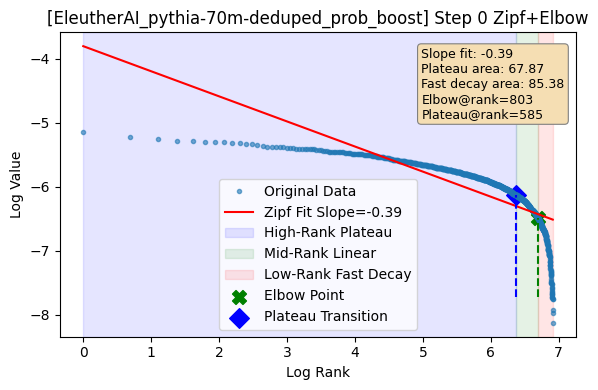

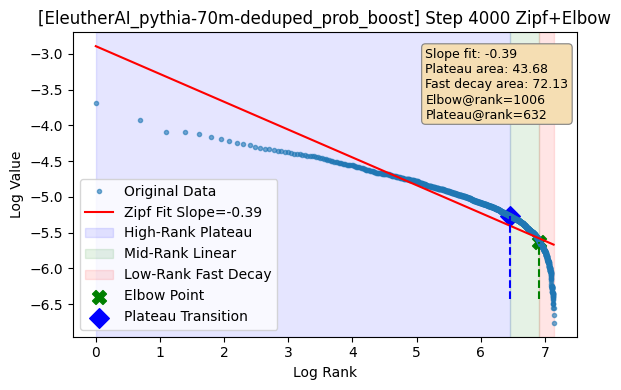

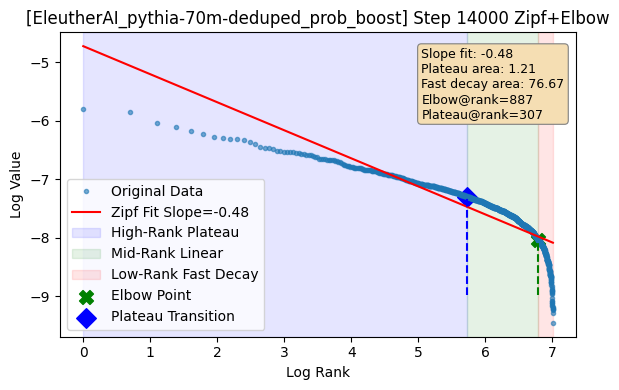

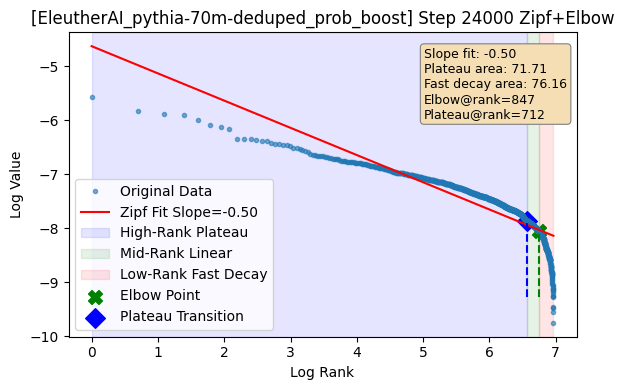

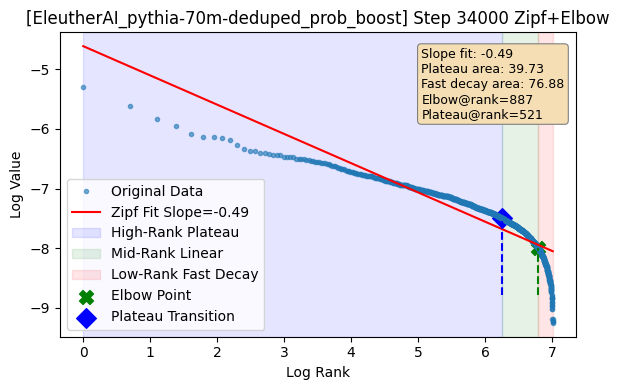

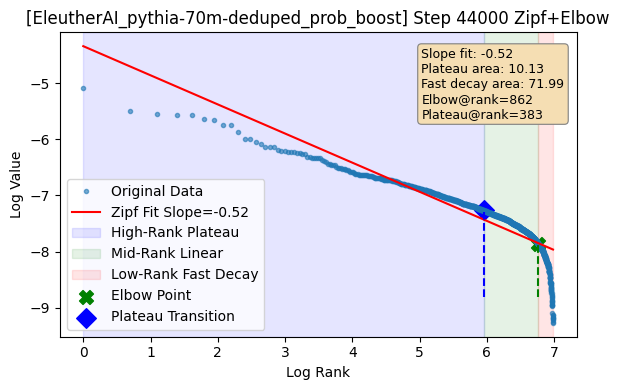

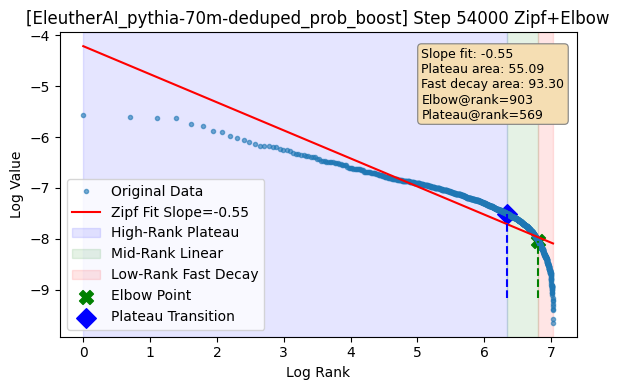

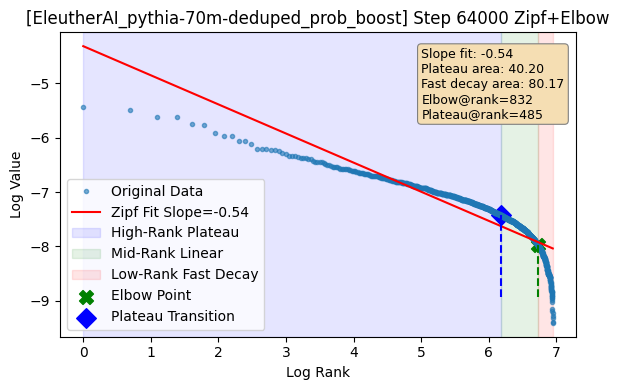

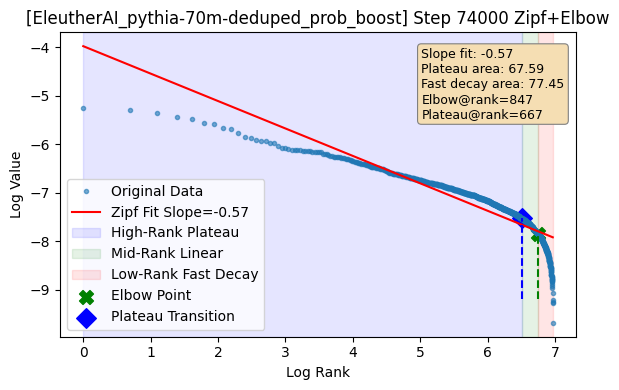

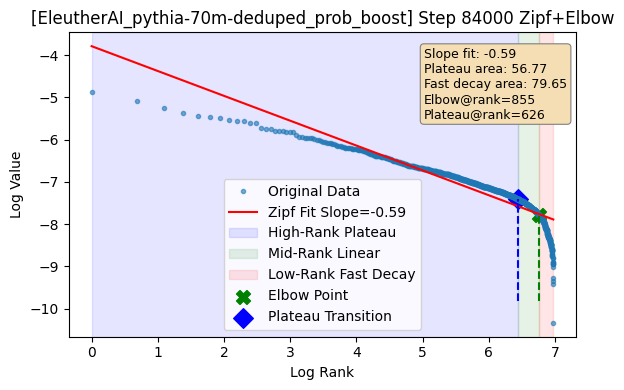

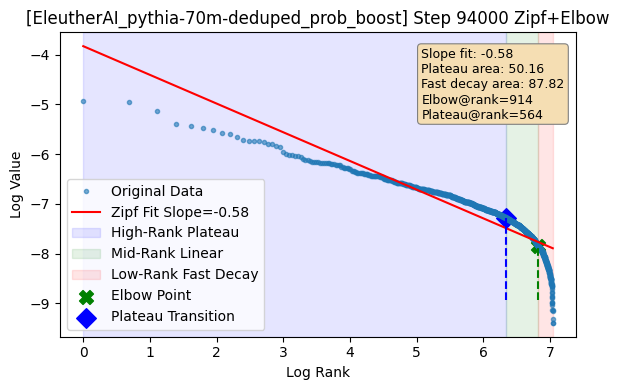

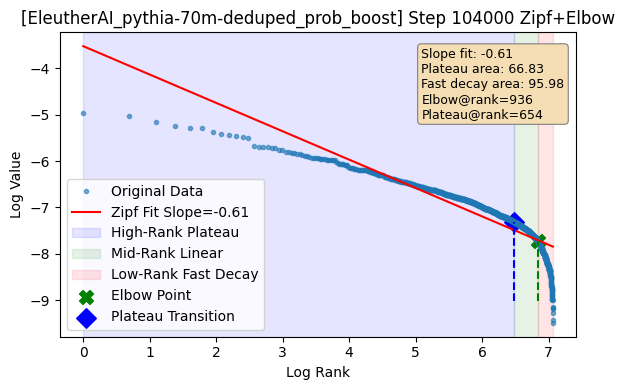

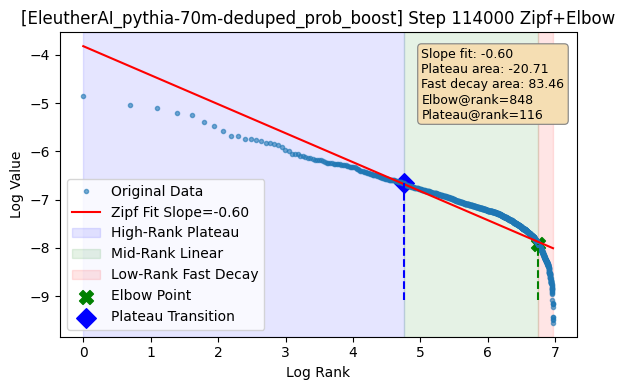

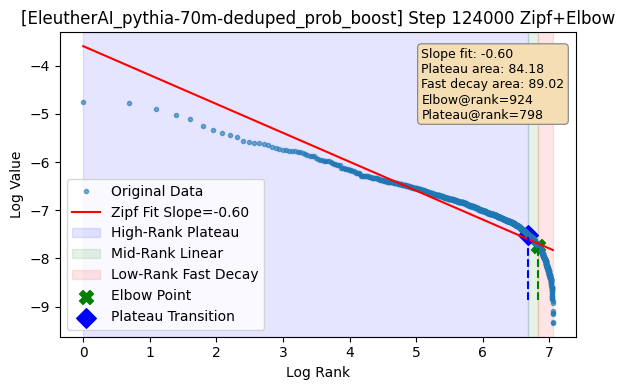

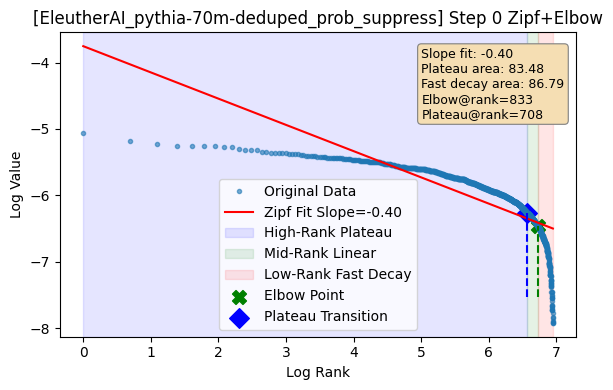

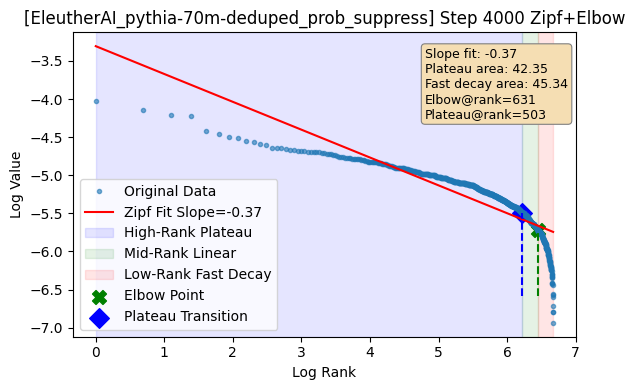

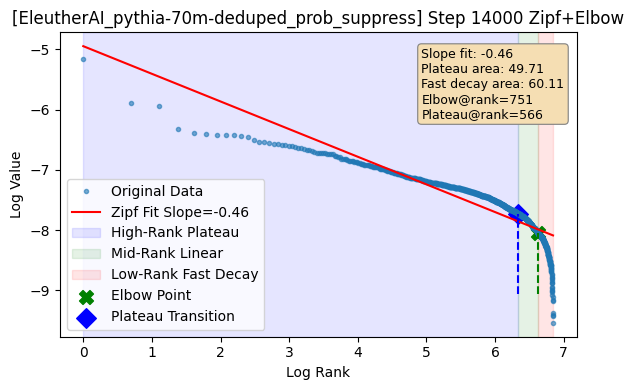

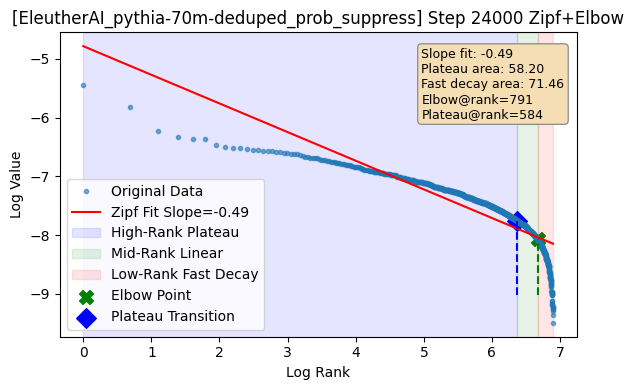

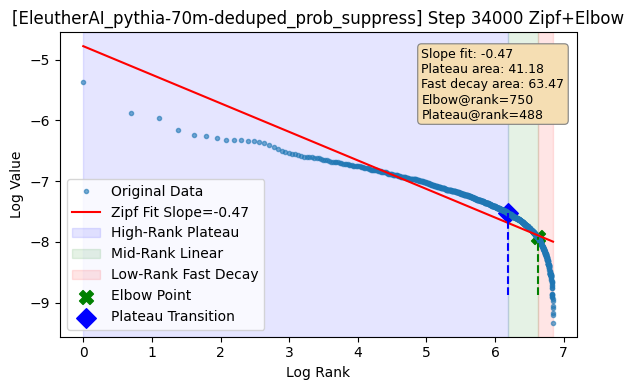

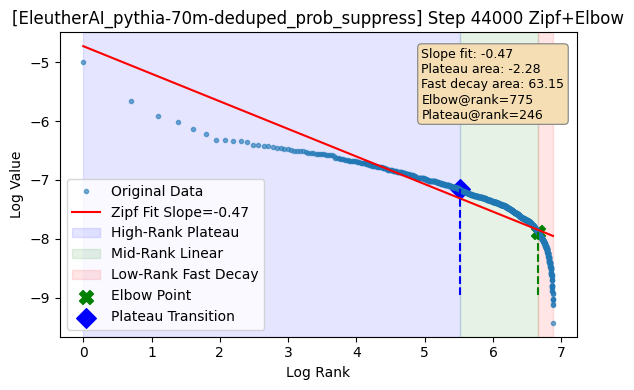

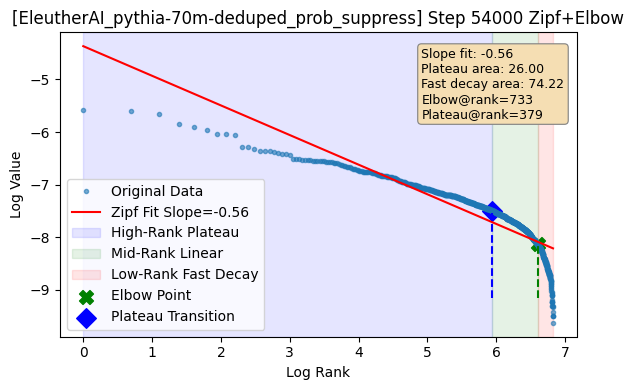

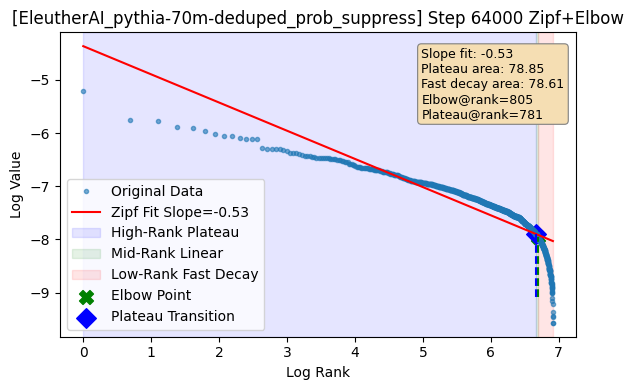

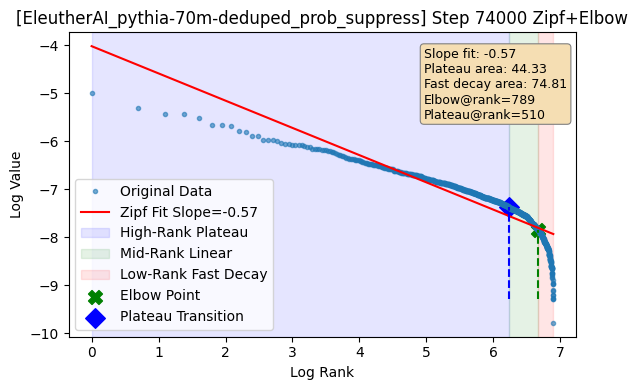

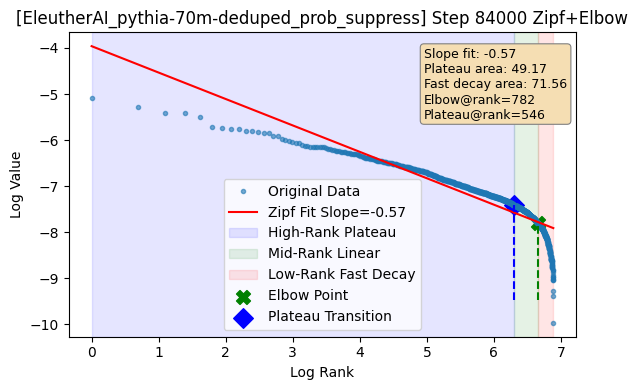

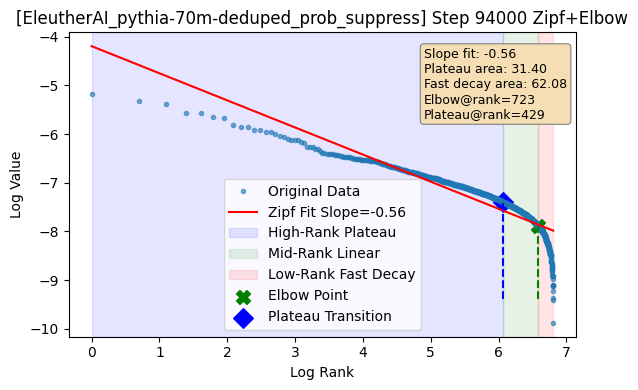

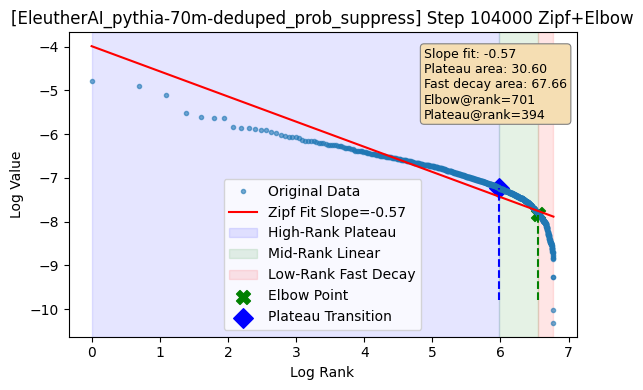

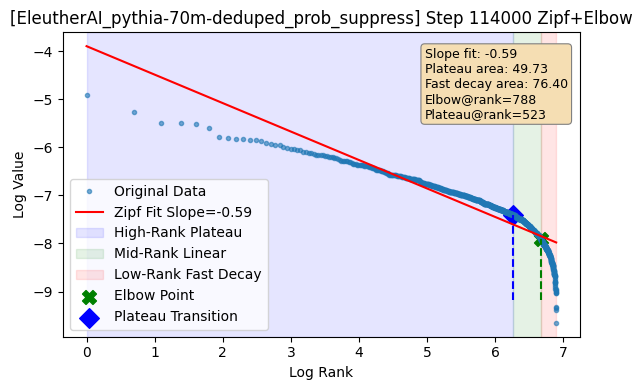

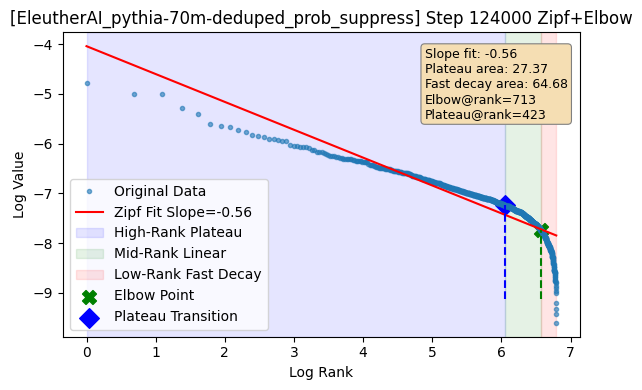

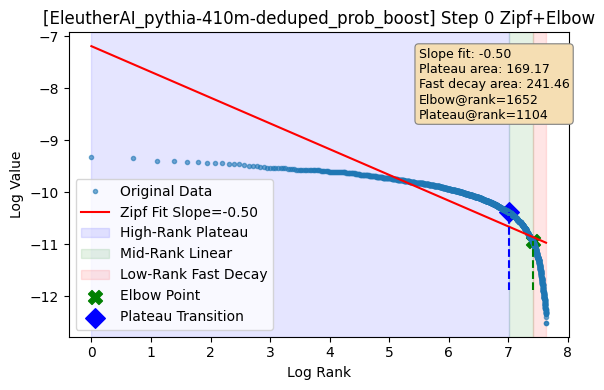

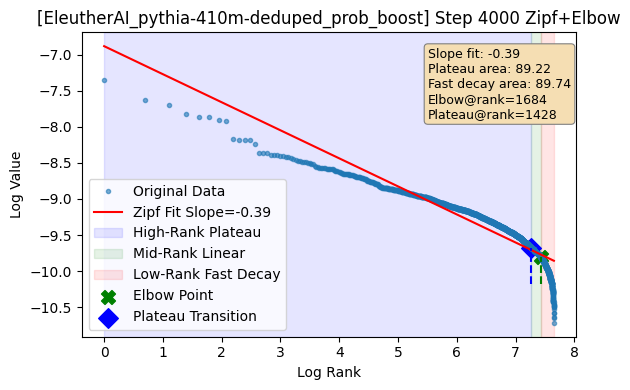

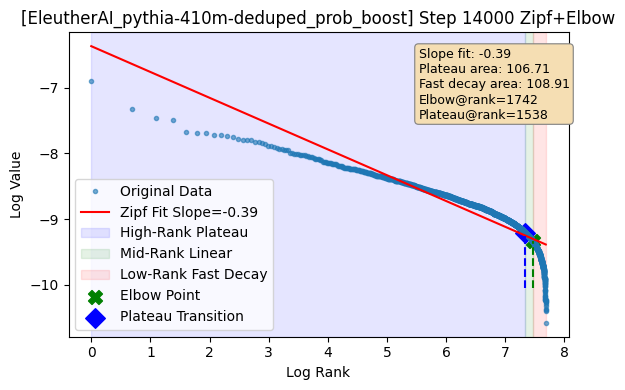

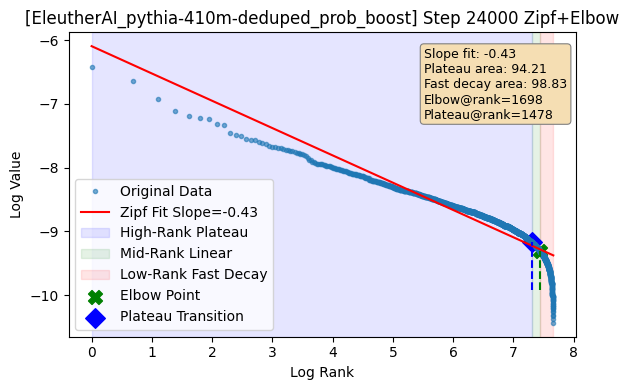

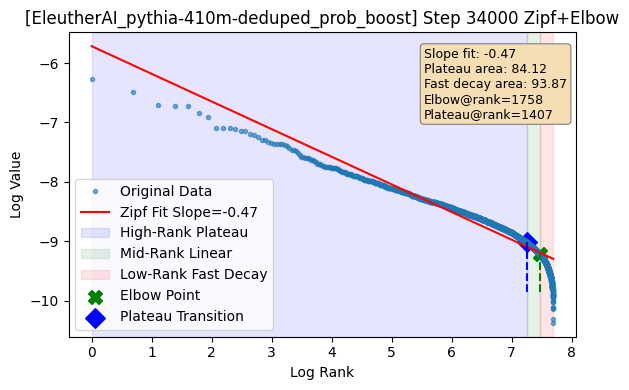

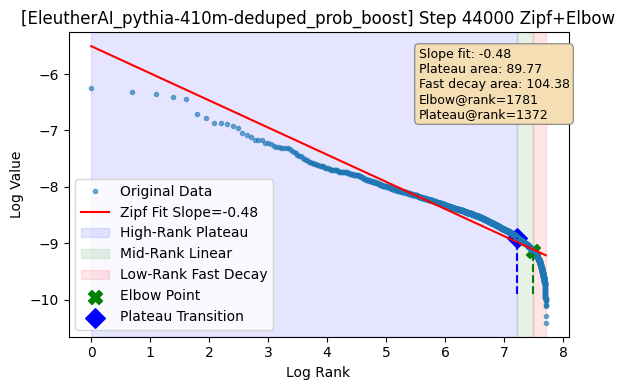

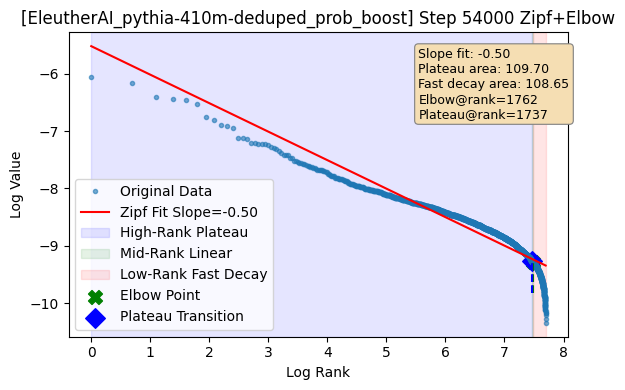

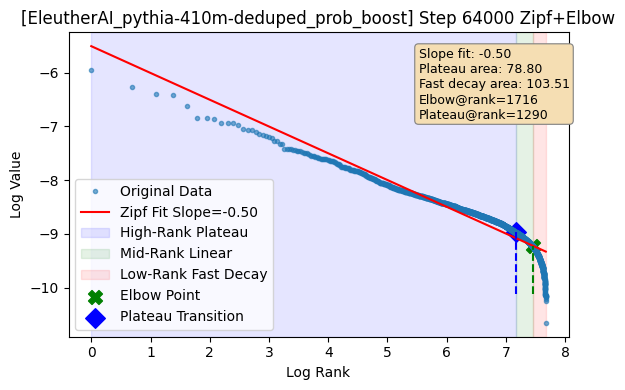

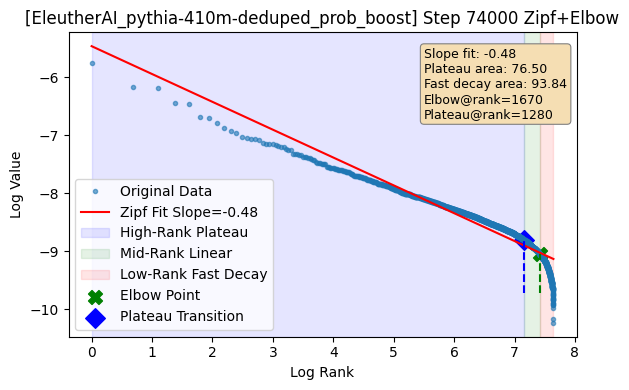

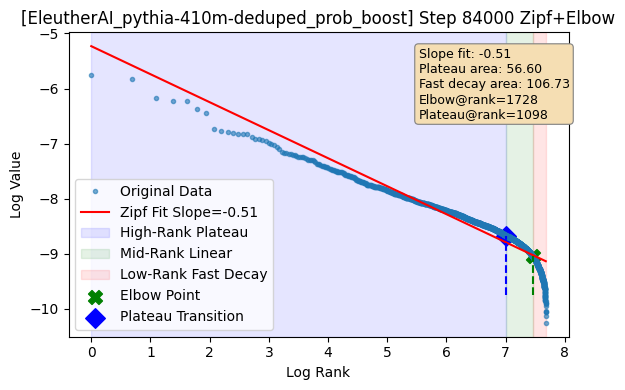

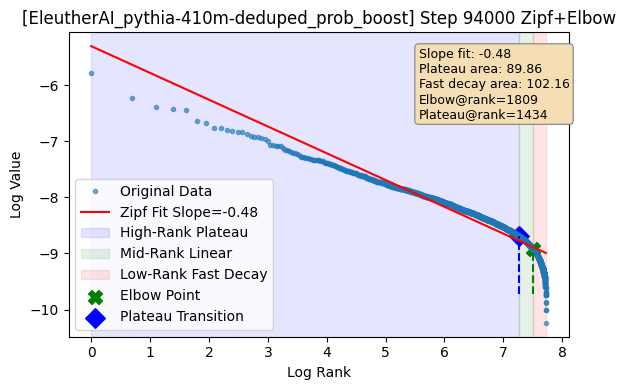

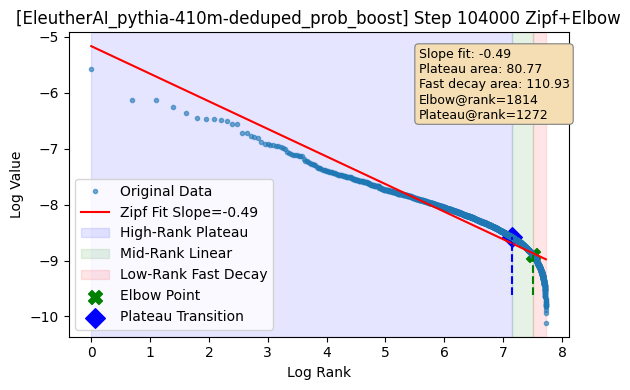

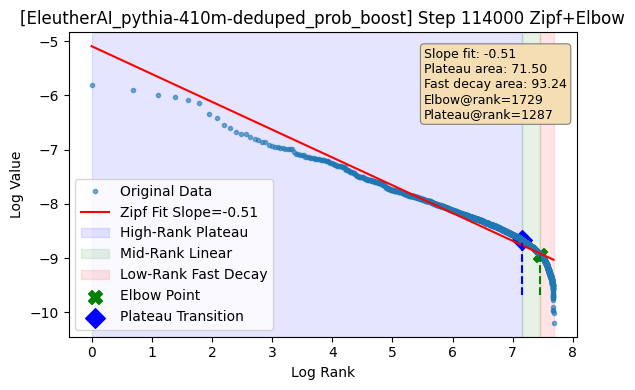

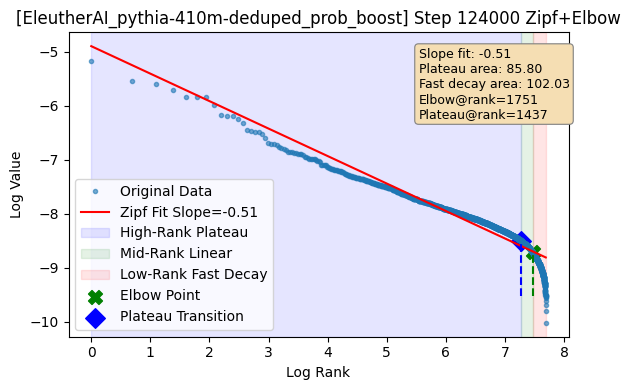

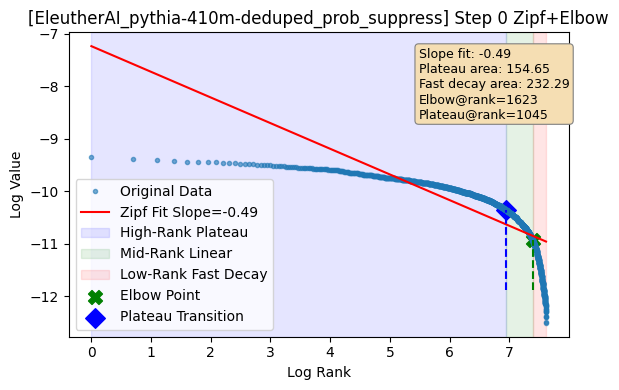

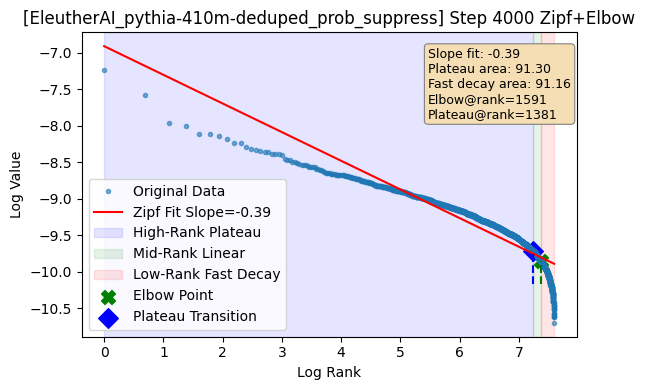

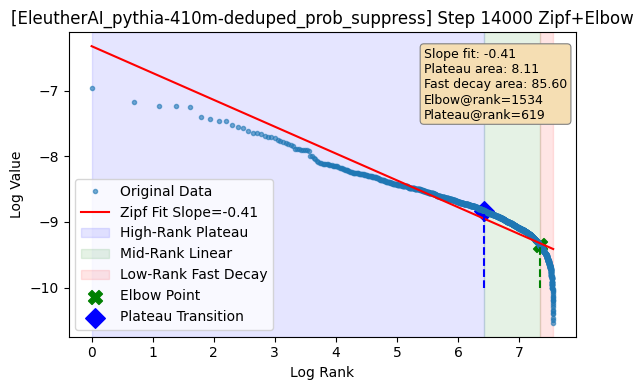

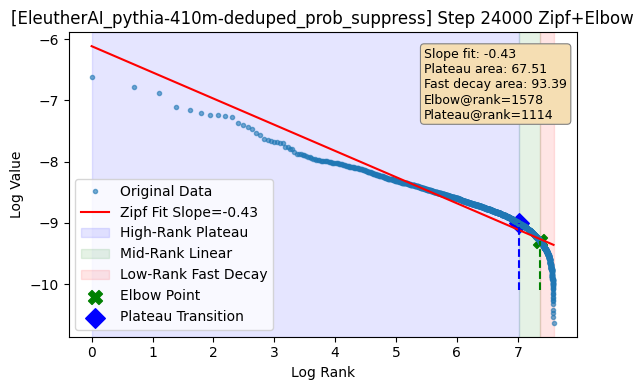

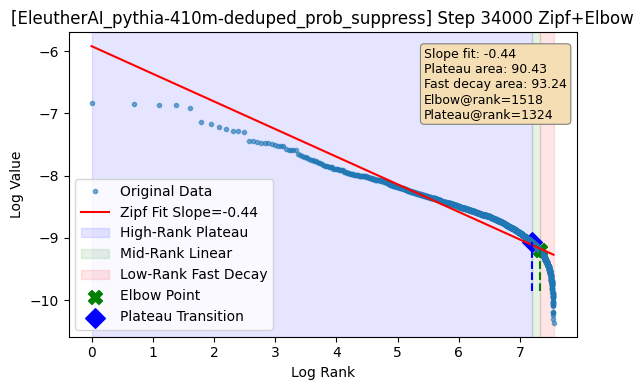

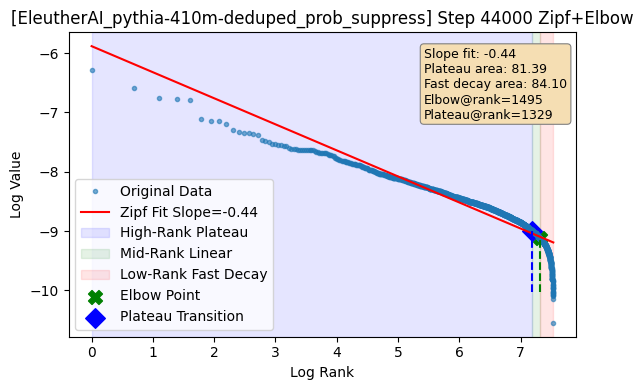

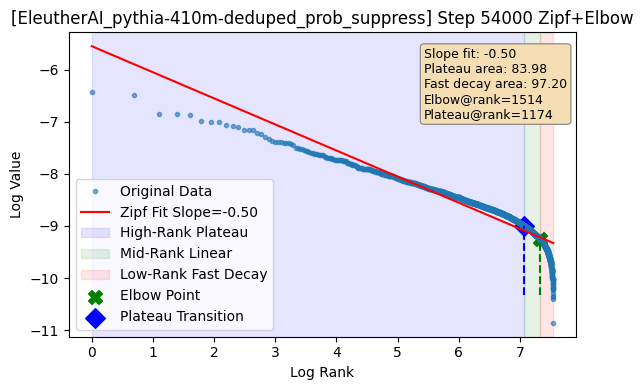

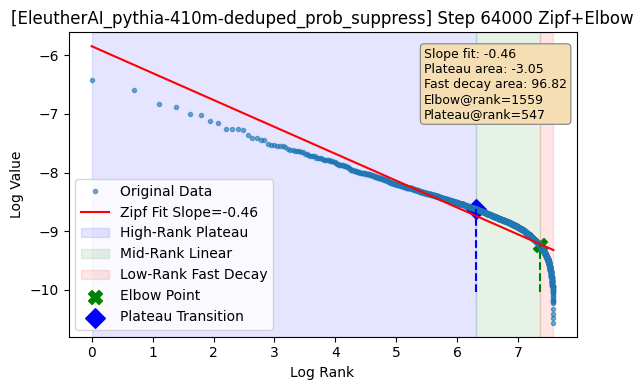

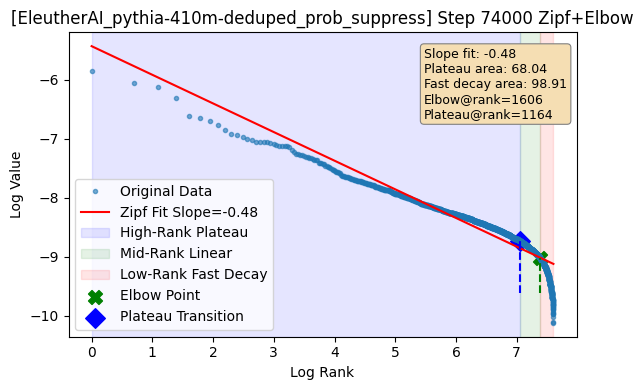

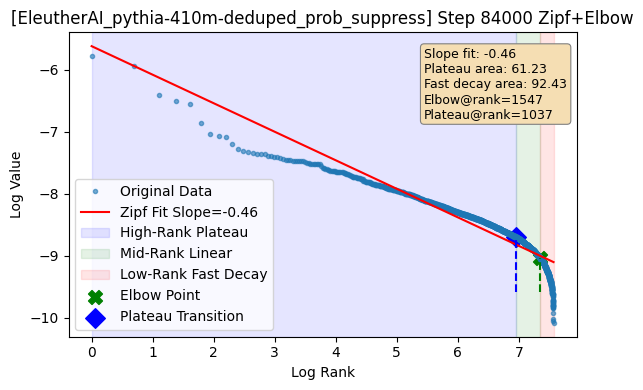

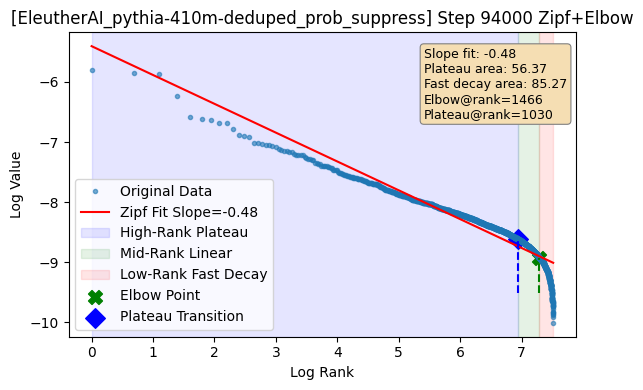

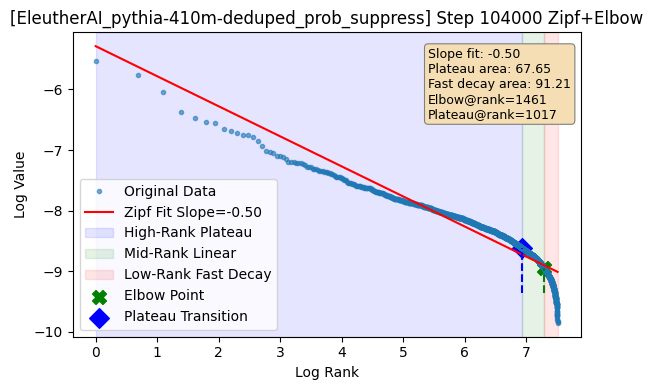

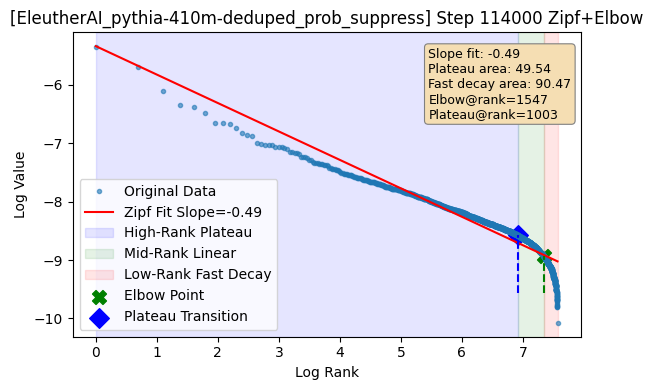

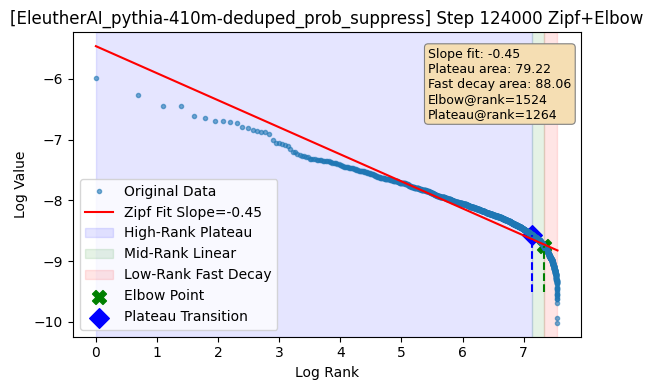

In [48]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path

def find_elbow_point(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 2000,
    threshold_multiplier: float = 1.0,
    min_rank_percentile: float = 0.001,
) -> dict:
    """Find the elbow point (transition to fast decay phase) in log-rank log-value data."""
    n = len(log_ranks)
    info = {"elbow_detected": False}
    # 动态调整 window_size（不超过数据长度的1/5）
    w = min(window_size, max(5, n // 5))
    if n >= w * 2:
        derivatives, idxs = [], []
        start = max(int(n * min_rank_percentile), w)
        for i in range(start, n - w):
            slope, _, _, _, _ = stats.linregress(
                log_ranks[i : i + w], log_vals[i : i + w]
            )
            derivatives.append(slope)
            idxs.append(i)
        derivatives = np.array(derivatives)
        if len(derivatives) > 1:
            diffs = np.abs(np.diff(derivatives))
            thr = diffs.mean() * threshold_multiplier
            sig = np.where(diffs > thr)[0]
            if len(sig):
                k = sig[np.argmax(diffs[sig])] + 1
                ei = idxs[k]
                return {
                    "elbow_detected": True,
                    "method": "slope_change",
                    "index": ei,
                    "log_rank": log_ranks[ei],
                    "log_value": log_vals[ei],
                }
    return info

def find_plateau_transition(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    zipf_slope: float,
    max_rank_index: int,  # Only consider data up to this index (elbow point)
    window_size: int = 100,  # Smaller window for early phase detection
    threshold_multiplier: float = 1.5,  # Lower threshold for early transition
    min_rank_percentile: float = 0.03,  # Start a bit from the beginning to avoid outliers
) -> dict:
    """Find the transition from plateau to linear decay phase."""
    # Only use data up to the elbow point
    ranks = log_ranks[:max_rank_index]
    vals = log_vals[:max_rank_index]
    
    n = len(ranks)
    info = {"plateau_detected": False}
    
    # Use smaller window appropriate for the earlier part of the curve
    w = min(window_size, max(5, n // 8))
    
    if n >= w * 2:
        derivatives, idxs = [], []
        start = max(int(n * min_rank_percentile), w)
        
        # Calculate local slopes across the data
        for i in range(start, n - w):
            slope, _, _, _, _ = stats.linregress(
                ranks[i : i + w], vals[i : i + w]
            )
            derivatives.append(slope)
            idxs.append(i)
        
        derivatives = np.array(derivatives)
        if len(derivatives) > 1:
            # Look for where slope changes significantly toward the zipf slope
            diffs = np.abs(np.diff(derivatives))
            thr = diffs.mean() * threshold_multiplier
            sig = np.where(diffs > thr)[0]
            
            # Also look for where the slope approaches the overall zipf_slope
            slope_diffs = np.abs(derivatives - zipf_slope)
            
            # Find points where both conditions are met:
            # 1. Significant change in slope
            # 2. Slope approaches the zipf_slope
            if len(sig) > 0:
                # Get candidates where slope is changing
                candidates = sig[slope_diffs[sig] < np.median(slope_diffs)]
                
                if len(candidates) > 0:
                    # Choose point with maximum change while being close to zipf_slope
                    k = candidates[np.argmax(diffs[candidates])]
                    transition_idx = idxs[k]
                    return {
                        "plateau_detected": True,
                        "method": "plateau_transition",
                        "index": transition_idx,
                        "log_rank": ranks[transition_idx],
                        "log_value": vals[transition_idx],
                    }
    
    return info

def zipf_and_elbow(values, **kwargs):
    """Analyze the distribution and identify both transition points."""
    arr = np.array(values)
    arr = arr[arr > 0]
    sorted_vals = np.sort(arr)[::-1]
    ranks = np.arange(1, len(sorted_vals)+1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # First fit the overall linear model (Zipf)
    coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    zipf_slope = coeffs[0]
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    # Find the elbow point (transition to fast decay)
    elbow = find_elbow_point(log_ranks, log_vals, **kwargs)
    
    # Initialize plateau info
    plateau_info = {"plateau_detected": False}
    
    # If elbow detected, use it as boundary to find plateau transition
    if elbow.get("elbow_detected", False):
        max_rank_index = elbow["index"]
        plateau_info = find_plateau_transition(
            log_ranks, log_vals, zipf_slope, max_rank_index,
            window_size=kwargs.get("plateau_window_size", 15),
            threshold_multiplier=kwargs.get("plateau_threshold_multiplier", 1.5),
            min_rank_percentile=kwargs.get("plateau_min_rank_percentile", 0.05)
        )
    
    return log_ranks, log_vals, zipf_line, coeffs, elbow, plateau_info

def calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info):
    """Calculate metrics for each phase."""
    metrics = {}
    
    if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
        # Get the indices for each phase boundary
        plateau_idx = plateau_info["index"]
        elbow_idx = elbow_info["index"]
        
        # Define the three phases
        plateau_mask = np.arange(len(log_ranks)) < plateau_idx
        linear_mask = (np.arange(len(log_ranks)) >= plateau_idx) & (np.arange(len(log_ranks)) < elbow_idx)
        fast_decay_mask = np.arange(len(log_ranks)) >= elbow_idx
        
        # Calculate metrics for each phase
        
        # 1. Phase sizes (number of neurons)
        metrics["plateau_size"] = np.sum(plateau_mask)
        metrics["linear_size"] = np.sum(linear_mask)
        metrics["fast_decay_size"] = np.sum(fast_decay_mask)
        
        # 2. Phase percentages
        total = len(log_ranks)
        metrics["plateau_percent"] = 100 * metrics["plateau_size"] / total
        metrics["linear_percent"] = 100 * metrics["linear_size"] / total
        metrics["fast_decay_percent"] = 100 * metrics["fast_decay_size"] / total
        
        # 3. Area metrics (deviation from linear fit)
        # Area above linear for plateau phase
        if np.any(plateau_mask):
            metrics["plateau_area"] = np.sum(log_vals[plateau_mask] - zipf_line[plateau_mask])
        else:
            metrics["plateau_area"] = 0
            
        # Area below linear for fast decay phase
        if np.any(fast_decay_mask):
            metrics["fast_decay_area"] = np.sum(zipf_line[fast_decay_mask] - log_vals[fast_decay_mask])
        else:
            metrics["fast_decay_area"] = 0
        
        # 4. Average slopes in each phase
        if np.sum(plateau_mask) >= 2:
            plateau_slope, _, _, _, _ = stats.linregress(
                log_ranks[plateau_mask], log_vals[plateau_mask]
            )
            metrics["plateau_slope"] = plateau_slope
        else:
            metrics["plateau_slope"] = None
            
        if np.sum(linear_mask) >= 2:
            linear_slope, _, _, _, _ = stats.linregress(
                log_ranks[linear_mask], log_vals[linear_mask]
            )
            metrics["linear_slope"] = linear_slope
        else:
            metrics["linear_slope"] = None
            
        if np.sum(fast_decay_mask) >= 2:
            fast_decay_slope, _, _, _, _ = stats.linregress(
                log_ranks[fast_decay_mask], log_vals[fast_decay_mask]
            )
            metrics["fast_decay_slope"] = fast_decay_slope
        else:
            metrics["fast_decay_slope"] = None
    
    return metrics

def plot_zipf_elbow(
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info, 
    title: str, save_path: Path
):
    """Create visualization with all three phases identified and metrics displayed."""
    plt.figure(figsize=(6, 4))
    plt.plot(log_ranks, log_vals, '.', alpha=0.6, label='Original Data')
    plt.plot(log_ranks, zipf_line, 'r-', linewidth=1.5,
             label=f'Zipf Fit Slope={coeffs[0]:.2f}')
    
    # Initialize text box
    box_text = [f"Slope fit: {coeffs[0]:.2f}"]
    
    # Calculate phase metrics if both transitions detected
    if elbow_info.get("elbow_detected") and plateau_info.get("plateau_detected"):
        metrics = calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info)
        
        # Add shaded regions for the three phases
        plt.axvspan(min(log_ranks), plateau_info["log_rank"], alpha=0.1, color='blue', 
                    label='High-Rank Plateau')
        plt.axvspan(plateau_info["log_rank"], elbow_info["log_rank"], alpha=0.1, color='green', 
                    label='Mid-Rank Linear')
        plt.axvspan(elbow_info["log_rank"], max(log_ranks), alpha=0.1, color='red', 
                    label='Low-Rank Fast Decay')
        
        # Add key metrics to text box
        if "plateau_area" in metrics:
            box_text.append(f"Plateau area: {metrics['plateau_area']:.2f}")
        if "fast_decay_area" in metrics:
            box_text.append(f"Fast decay area: {metrics['fast_decay_area']:.2f}")
    
    # Mark the elbow point (Linear to Fast Decay transition)
    if elbow_info.get("elbow_detected"):
        lr_elbow = elbow_info["log_rank"]
        lv_elbow = elbow_info["log_value"]
        idx_elbow = elbow_info["index"]
        mtd_elbow = elbow_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_elbow, lv_elbow, c='green', marker='X', s=100, label='Elbow Point')
        plt.vlines(lr_elbow, ymin=min(log_vals)*0.95, ymax=lv_elbow,
                 colors='green', linestyles='--')
        
        box_text.append(f"Elbow@rank={idx_elbow}")
    else:
        box_text.append("!NO Elbow Point")
    
    # Mark the plateau transition (Plateau to Linear transition)
    if plateau_info.get("plateau_detected"):
        lr_plateau = plateau_info["log_rank"]
        lv_plateau = plateau_info["log_value"]
        idx_plateau = plateau_info["index"]
        mtd_plateau = plateau_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_plateau, lv_plateau, c='blue', marker='D', s=100, 
                   label='Plateau Transition')
        plt.vlines(lr_plateau, ymin=min(log_vals)*0.95, ymax=lv_plateau,
                 colors='blue', linestyles='--')
        
        box_text.append(f"Plateau@rank={idx_plateau}")
    else:
        box_text.append("!NO Plateau Detected")
    
    # Add text box with metrics
    
    plt.gca().text(
    0.7, 0.95, "\n".join(box_text),
    transform=plt.gca().transAxes,
    fontsize=9, va='top', 
    bbox=dict(boxstyle="round,pad=0.3", fc="wheat", ec="gray", lw=0.8)
)
    
    plt.title(title)
    plt.xlabel("Log Rank")
    plt.ylabel("Log Value")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)


def run_analysis(root_dir: str, output_dir: str):
    """
    批量遍历目录下所有 500_all.csv 文件，
    对每个 step 执行 Zipf+Elbow 分析和 KDE 分布绘图，
    结果按条件命名并保存到 output_dir。
    """
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    csv_files = list(root_path.rglob("500_all.csv"))
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")

        # Zipf + Elbow 分析
        for _, row in df.iterrows():
            step = row["step"]
            vals = row["abs_delta_loss_post_ablation"]
            lr, lv, zl, coeffs, elbow_info, plateau_info = zipf_and_elbow(vals)
            
            title = f"[{rel_id}] Step {step} Zipf+Elbow"
            save_p = output_path / f"{rel_id}_step{step}_zipf_elbow.png"
            plot_zipf_elbow(lr, lv, zl, coeffs, elbow_info,plateau_info,  title, save_p)

        plt.title(f"[{rel_id}] All Steps ΔLoss KDE")
        plt.xlabel("ΔLoss")
        plt.ylabel("Density")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.close()


run_analysis(
    root_dir="/Users/jliu/workspace/RAG/results/selection/neuron/longtail_50",
    output_dir="/Users/jliu/workspace/RAG/fig/delta_loss_1"
)

In [2]:

class JsonProcessor:
    """Class for handling JSON serialization with NumPy type conversion."""
    @staticmethod
    def load_json1(filepath: Path) -> dict:
        """Load a JSON file into a dictionary."""
        with open(filepath, encoding="utf-8") as f:
            return json.load(f)
        
    

    def load_json(filepath):
        with open(filepath, encoding="utf-8") as f:
            content = f.read()
        try:
            # Try to parse just the first valid JSON object
            decoder = json.JSONDecoder()
            obj, end = decoder.raw_decode(content)
            return obj  # obj is your dictionary
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            return None

# case style for the results
case_styles = {
    "boost":    {"marker":"o","linestyle":"-"},
    "suppress": {"marker":"s","linestyle":"--"},
    "random": {"marker":"^","linestyle":":"},
}

case_styles_group =  {"marker":"o","linestyle":"-"}
    
colors = {
    10: 'blue',
    50: 'green',
    100: 'red',
}


SETTING_MAP = {"group_best":"gbest","group_target_size":"gtsize","individual":"indiv"}
MODEL_MAP   = {"pythia-70m-deduped":"70m","pythia-410m-deduped":"410m"}


## Geometric analyses


In [3]:


def slugify(text):
    return re.sub(r'\W+','_', text).strip('_').lower()


# plot the results
def plot_metrics_by_model(
    df: pd.DataFrame,
    metric: str,
    shot: int,
    out_dir: Path,
    show: bool = False
):
    """
    For each model in df, plot 'metric' vs categorical step index,
    with separate lines for each sample_size.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    for model, group in df.groupby('model'):
        # Unique sorted steps across this model
        steps = sorted(group['step'].unique())
        step_to_idx = {s: i for i, s in enumerate(steps)}

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot each sample size
        for sample_size, color in zip(sorted(group['sample_size'].unique()), ['blue', 'green', 'red']):
            sub = group[group['sample_size'] == sample_size]
            # Map actual step values to category index
            x = [step_to_idx[val] for val in sub['step']]
            ax.plot(
                x,
                sub[metric],
                marker='o',
                color=color,
                label=f"{sample_size} samples"
            )

        # Align x-axis labels to categories
        ax.set_xticks(list(range(len(steps))))
        ax.set_xticklabels(steps, rotation=45)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f"{model} | {shot}-Shot | {metric.replace('_',' ').title()}")
        ax.legend(title='Sample Size')
        ax.grid(alpha=0.3)

        # Save
        slug = slugify(model)
        fname = out_dir / f"{slug}_shot{shot}_{metric}.png"
        fig.tight_layout()
        fig.savefig(fname, dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)
        print(f"Saved plot to {fname}")




In [ ]:
class DataProcessor:
    """Process and analyze dimensional data from JSON files."""

    def __init__(
        self, 
        data_dir: Path,
        space_type: str, 
        model_name_lst: list[str], 
        sample_size_lst: list[int], 
        group_type_lst: list[str],
        case_styles: dict[str],
        colors: dict[str],
        setting_map: dict[str] = SETTING_MAP,
        model_map: dict[str] = MODEL_MAP
    ):
        """Initialize the DataProcessor with the data directory and processing parameters."""
        self.data_dir = data_dir
        self.space_type = space_type
        self.model_name_lst = model_name_lst
        self.sample_size_lst = sample_size_lst
        self.group_type_lst = group_type_lst
        self.filepath_lst, self.file_info = self.get_filepath_list()
        self.case_styles = case_styles
        self.colors = colors
        self.setting_map = setting_map
        self.model_map = model_map
    
    def get_filepath_list(self) -> tuple[list[Path], list[list[str]]]:
        """Generate lists of file paths based on initialized parameters."""
        filepath_lst = []
        file_info = []
        
        for group_type in self.group_type_lst:
            for model_name in self.model_name_lst:
                for sample_size in self.sample_size_lst:
                    filepath_lst.append(
                        self.data_dir / group_type / self.space_type / "longtail_50/EleutherAI" / 
                        model_name / "prob" / f"500_{sample_size}.json"
                    )
                    file_info.append([model_name, sample_size, group_type])
        
        return filepath_lst, file_info
    
    
    def load_single_dim(self, data_all: dict, step: str, file_info: list[str]) -> pd.DataFrame:
        """Extract stepwise stats from JSON data."""
        try:
            data = data_all[step]["dimensionality"]
            records = [{
                'model': file_info[0],
                'step': step,
                'sample_size': file_info[1],
                'group_type': file_info[2],
                'boost': data['boost'].get('dim_prop'),
                'suppress': data['suppress'].get('dim_prop'),
                'random': data['random_1'].get('dim_prop'),
            }]
            return pd.DataFrame.from_records(records)
        except Exception:
            print(f"Error processing file info: {file_info}")
            return None
    
    def load_single_between(self, data_all: dict, step: str, file_info: list[str]) -> pd.DataFrame:
        """Extract stepwise stats from JSON data."""
        
        data = data_all[step]["orthogonality"]["between"]
        records = [{
            'model': file_info[0],
            'step': step,
            'sample_size': file_info[1],
            'group_type': file_info[2],
            "boost_vs_random_1": data["boost_vs_random_1"].get('mean_cross_cosine_similarity'),
            "suppress_vs_random_1": data["suppress_vs_random_1"].get('mean_cross_cosine_similarity'),
            "boost_vs_suppress": data["boost_vs_suppress"].get('mean_cross_cosine_similarity'),
            "random_1_vs_random_2": data["random_1_vs_random_2"].get('mean_cross_cosine_similarity'),
        }]
        return pd.DataFrame.from_records(records)
    
    
    
    def load_data(self,stat:str) -> pd.DataFrame:
        """Run the full data loading and plotting pipeline."""
        # Load all file paths
        filepath_lst, file_info_lst = self.get_filepath_list()
        
        # Load all files
        df = pd.DataFrame()
        for file_idx, filepath in enumerate(filepath_lst):
            data_all = JsonProcessor.load_json(filepath)
            # Loop through different steps
            for step in data_all.keys():
                if stat == "dim":
                    df_row = self.load_single_dim(data_all, step, file_info_lst[file_idx])
                if stat == "across":
                    df_row = self.load_single_between(data_all, step, file_info_lst[file_idx])
                if df_row is not None:
                    df = pd.concat([df, df_row])
        # sort and convert dataformat
        df['step'] = df['step'].astype(int)
        return df.sort_values(['model','step'])
    
    def plot_dim(
        self,
        df: pd.DataFrame,
        metric_lst: list[str],
        out_dir: Path,
        show: bool = True,
        y_range = [0.85,1]
    ) -> None:
        """Plot multiple metrics together for a specific model and sample size."""
        # Create output directory if it doesn't exist
        out_dir.mkdir(parents=True, exist_ok=True)
        df_grouped = df.groupby(["model","group_type"])
        # loop over the model
        for plot_info, df_group in df_grouped:
                # loop over sample sizes
                data = df_group.groupby("sample_size")
                for sample_size, data_group in data:
                    for metric in metric_lst:
                        style = self.case_styles[metric]
                        plt.plot(
                            data_group["step"].to_list(),
                            data_group[metric].to_list(),
                            color=colors[sample_size],
                            marker=style["marker"],
                            linestyle=style["linestyle"],
                            label=f"{sample_size}_{metric}"
                        )
                        
                plt.ylim(y_range)
                plt.title(f"{self.model_map[plot_info[0]]} | {self.setting_map[plot_info[1]]} | dim_prop")
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                plt.grid(alpha=0.3)
                if show:
                    plt.show()

        
    def plot_ortho(
        self,
        df: pd.DataFrame,
        metric_lst: list[str],
        out_dir: Path,
        show: bool = True,
        y_range = [0.85,1]
    ) -> None:
        """Plot multiple metrics together for a specific model and sample size."""
        # Create output directory if it doesn't exist
        out_dir.mkdir(parents=True, exist_ok=True)
        df_grouped = df.groupby(["model","group_type"])
        # loop over the model
        for plot_info, df_group in df_grouped:
                # loop over sample sizes
                data = df_group.groupby("sample_size")
                
                for metric in metric_lst:
                    for sample_size, data_group in data:
                        plt.plot(
                            data_group["step"].to_list(),
                            data_group[metric].to_list(),
                            color=colors[sample_size],
                            marker=self.case_styles["marker"],
                            linestyle=self.case_styles["linestyle"],
                            label=sample_size
                        )
                    plt.ylim(y_range)
                    plt.title(f"{self.model_map[plot_info[0]]} | {self.setting_map[plot_info[1]]} | {metric}")
                    plt.legend()
                    plt.grid(alpha=0.3)
                    if show:
                        plt.show()



In [ ]:
# loop over differento conditions
out_dir= ROOT_dir/'fig/geometry/weight'
metric_lst = ["boost","suppress","random"]
# intialize the class
data_processor = DataProcessor(
    data_dir = ROOT_dir/'results/geometry/',
    space_type = "weight",
    model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"], 
    sample_size_lst = [10,50,100],
    group_type_lst = ["individual","group_best","group_target_size"],
    case_styles =case_styles,
    colors=colors
)

# load the effective dimension
df = data_processor.load_data("dim")
data_processor.plot_dim(
        df=df,
        metric_lst = metric_lst,
        out_dir = out_dir,
        show = True
    )

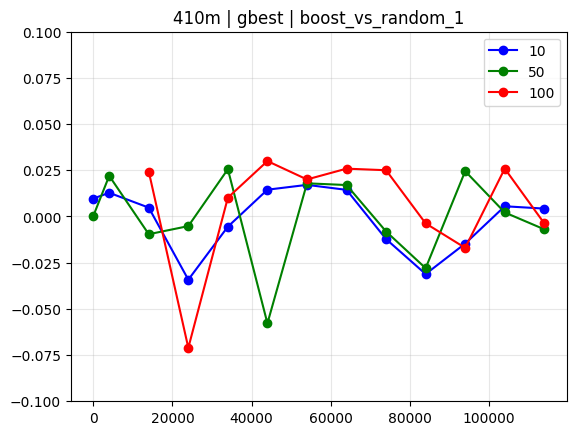

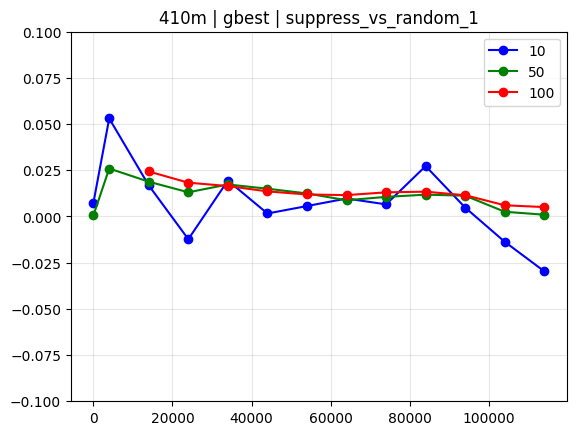

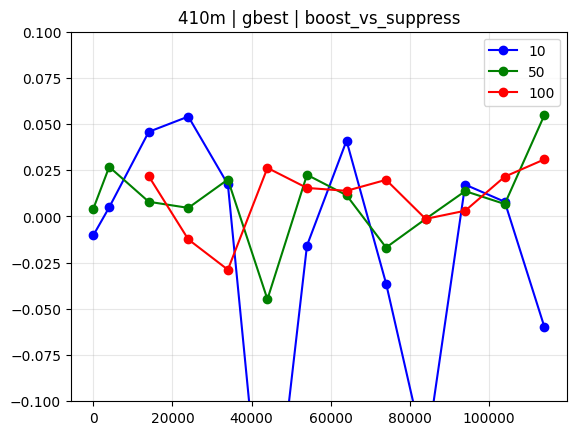

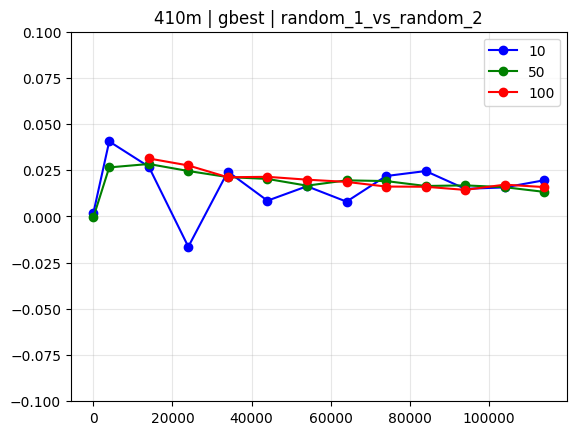

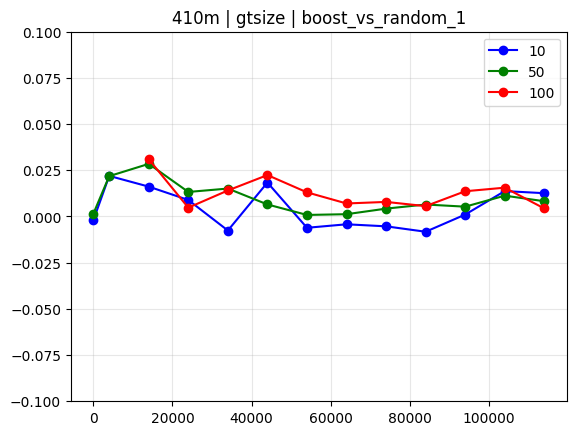

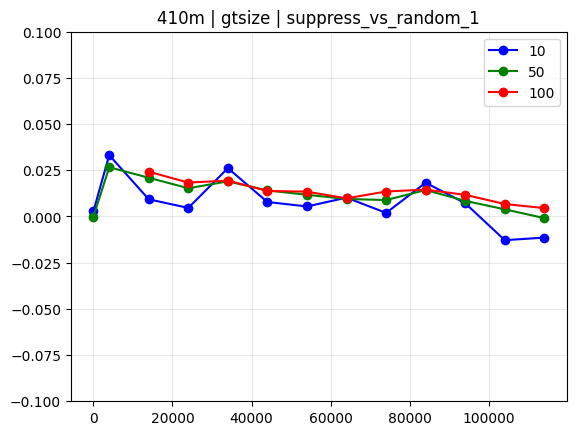

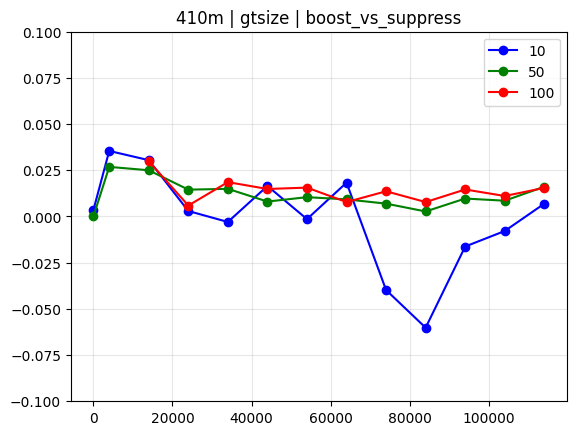

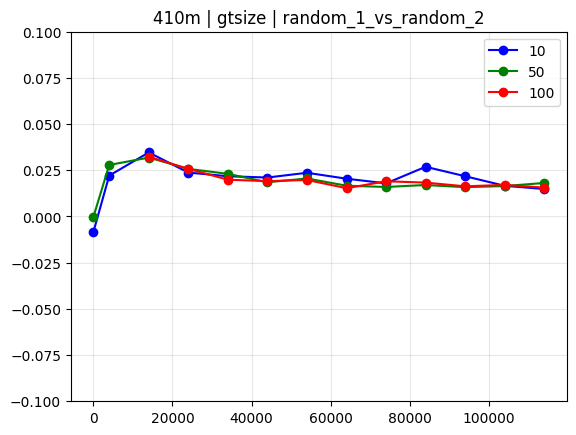

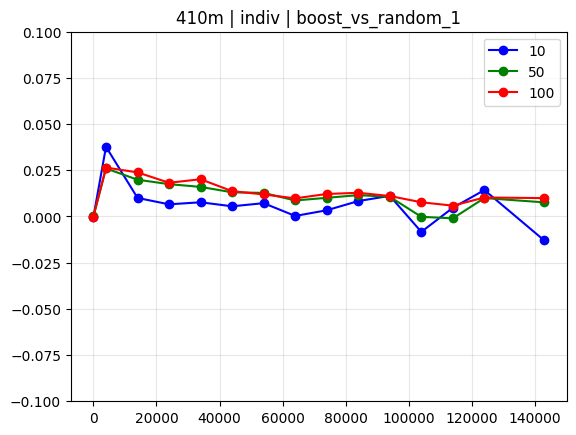

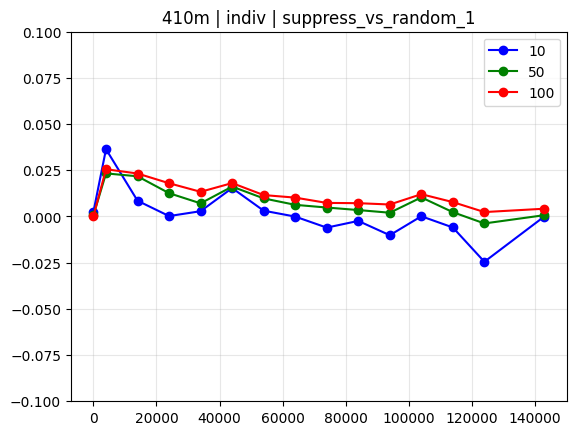

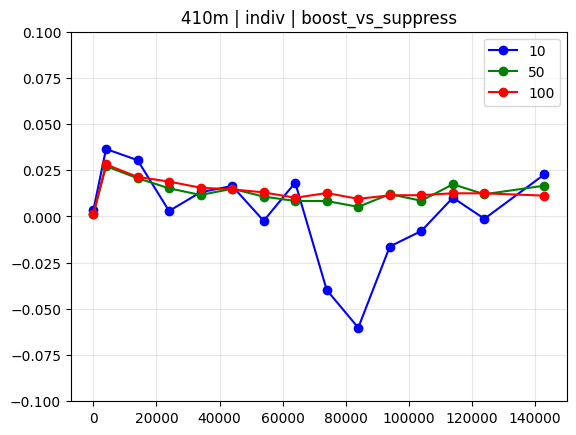

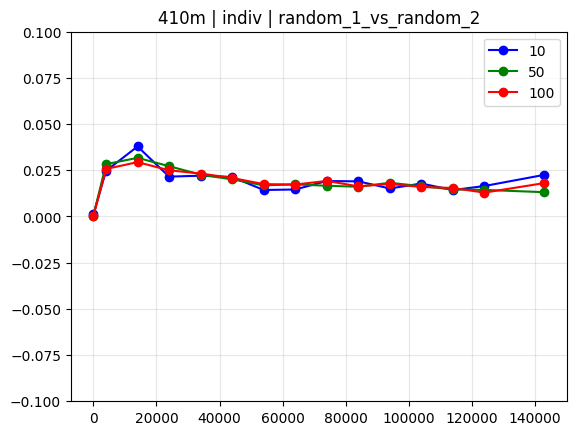

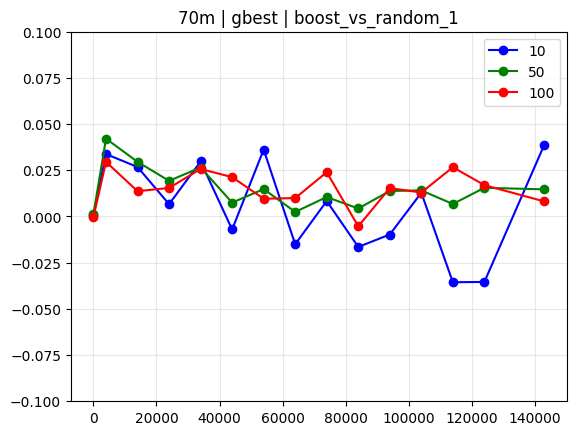

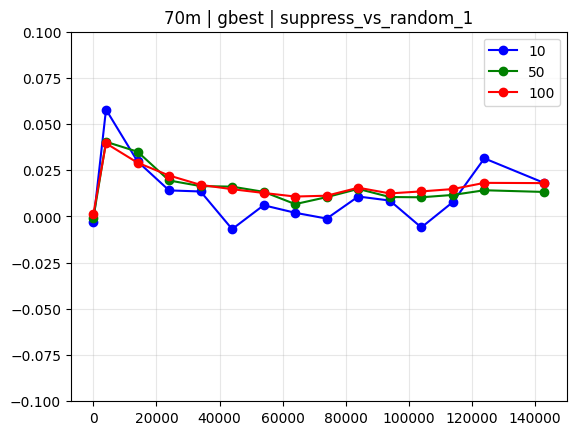

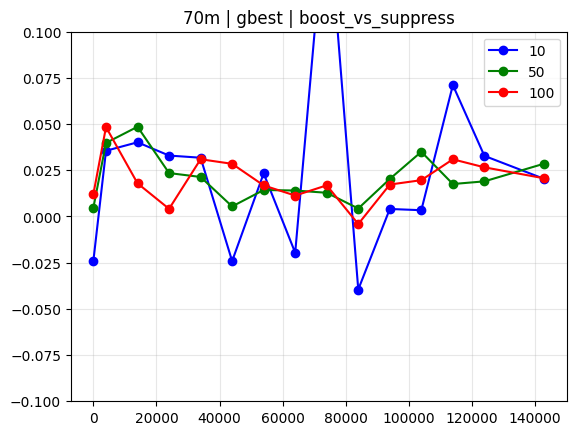

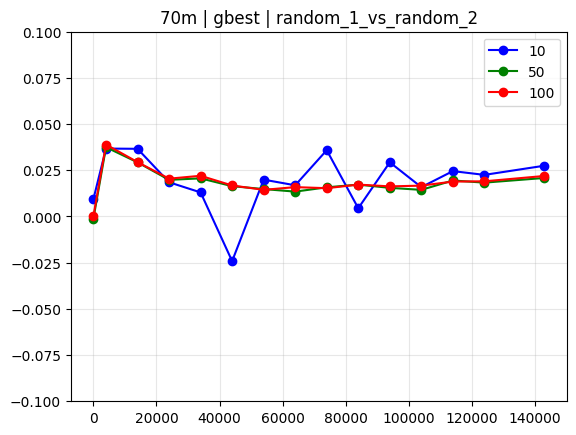

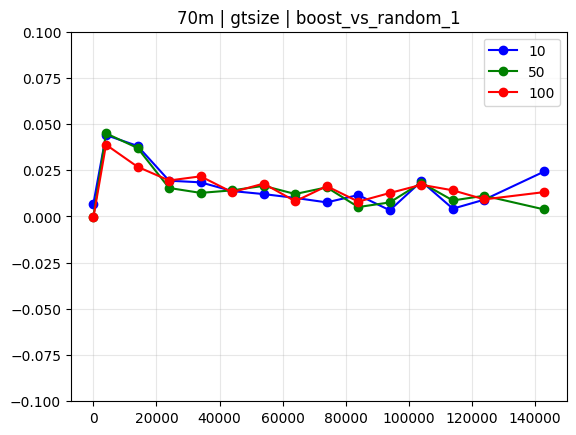

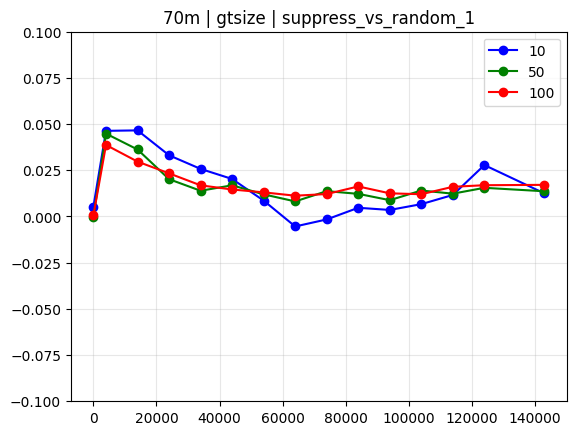

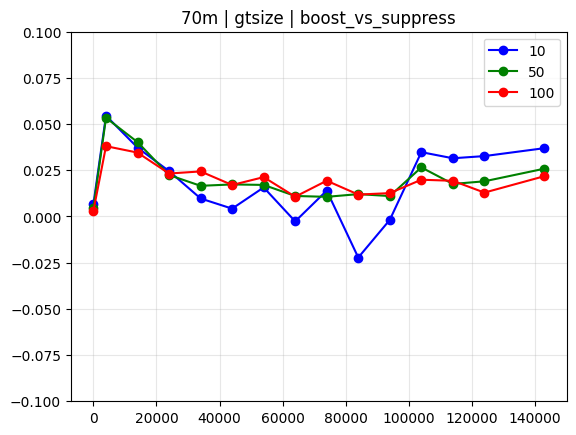

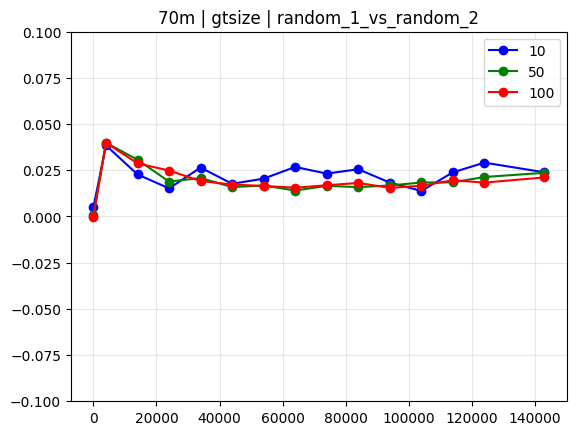

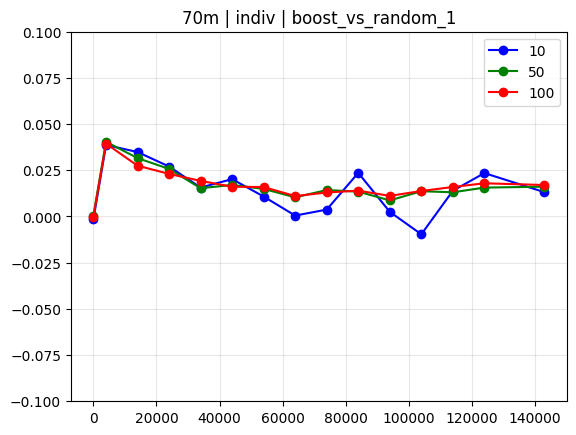

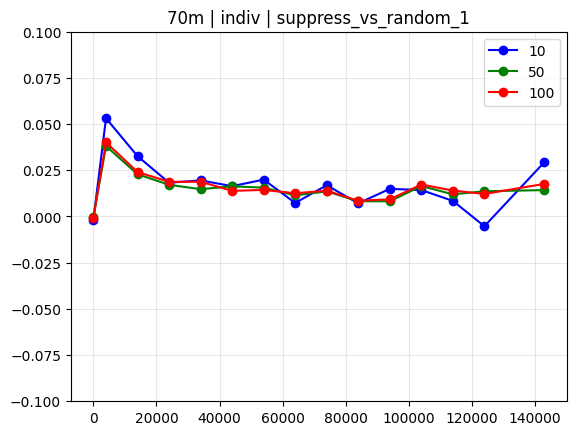

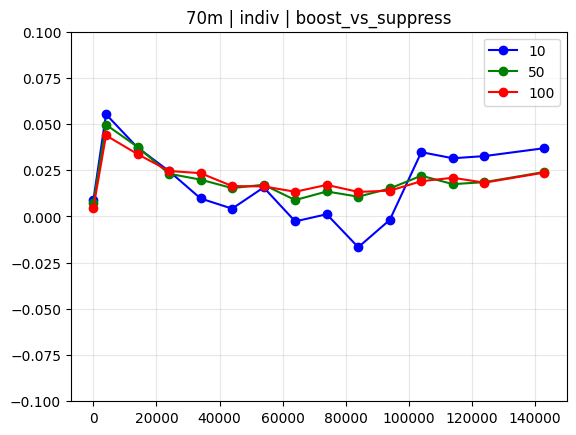

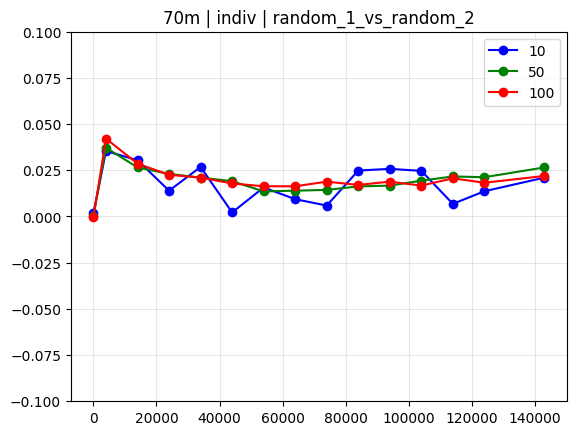

In [131]:
# loop over differento conditions
out_dir= ROOT_dir/'fig/geometry/weight'
# intialize the class
data_processor = DataProcessor(
    data_dir = ROOT_dir/'results/geometry/',
    space_type = "weight",
    model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"], 
    sample_size_lst = [10,50,100],
    group_type_lst = ["individual","group_best","group_target_size"],
    case_styles =case_styles_group,
    colors=colors
)

metric_lst = ['boost_vs_random_1','suppress_vs_random_1', 'boost_vs_suppress', 'random_1_vs_random_2']
df = data_processor.load_data("across")
data_processor.plot_ortho(
        df=df,
        metric_lst = metric_lst,
        out_dir = out_dir,
        show = True,
        y_range = [-0.1,0.1]
    )

## Reflection analyses

In [9]:
def get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)->list:
    """Iterate file names."""
    filepath_lst = []
    file_info = []
    for model_name in model_name_lst:
        for step in step_lst:
            for sample_size in sample_size_lst:
                for class_num in class_num_lst:
                    for group_type in group_type_lst: 
                        filepath_lst.append(DATA_DIR / model_name / "prob" / str(step) / "500" / str(sample_size) / str(class_num) / group_type / filename)
                        file_info.append([model_name,step,sample_size])
    return filepath_lst, file_info


def load_data(filepath, file_info):
    """Extract stat form json file."""
    try:
        data = json.loads(filepath.read_text(encoding='utf-8'))
        records = []
        records.append({
            'model': file_info[0],
            'step': file_info[1],
            'sample_size': file_info[2],
            'special': data["1"].get('delta_loss_diff'),
            'common': data["-1"].get('delta_loss_diff'),
        })
        return pd.DataFrame.from_records(records)
    except:
        print(filepath)
        return None
    

# plot the results
def plot_metrics_by_model(
    df: pd.DataFrame,
    metric: str,
    shot: int,
    out_dir: Path,
    show: bool = False
):
    """
    For each model in df, plot 'metric' vs categorical step index,
    with separate lines for each sample_size.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    for model, group in df.groupby('model'):
        # Unique sorted steps across this model
        steps = sorted(group['step'].unique())
        step_to_idx = {s: i for i, s in enumerate(steps)}

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot each sample size
        for sample_size, color in zip(sorted(group['sample_size'].unique()), ['blue', 'green', 'red']):
            sub = group[group['sample_size'] == sample_size]
            # Map actual step values to category index
            x = [step_to_idx[val] for val in sub['step']]
            ax.plot(
                x,
                sub[metric],
                marker='o',
                color=color,
                label=f"{sample_size} samples"
            )

        # Align x-axis labels to categories
        ax.set_xticks(list(range(len(steps))))
        ax.set_xticklabels(steps, rotation=45)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f"{model} | {shot}-Shot | {metric.replace('_',' ').title()}")
        ax.legend(title='Sample Size')
        ax.grid(alpha=0.3)

        # Save
        slug = slugify(model)
        fname = out_dir / f"{slug}_shot{shot}_{metric}.png"
        fig.tight_layout()
        fig.savefig(fname, dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)
        print(f"Saved plot to {fname}")



def run_pipeline(DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename):
    """Run the plotting pipeline."""
    # load all file pathss
    filepath_lst, file_info_lst = get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)
    # load all files
    df = pd.DataFrame()
    for file_idx, filepath in enumerate(filepath_lst):
        df_row = load_data(filepath, file_info_lst[file_idx])
        df = pd.concat([df,df_row])

    # plot out the results
    for metric in metric_lst:
        plot_metrics_by_model(
            df,
            metric=metric,
            shot = 2,
            out_dir= out_dir,
            show = True
        )




/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/24000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/34000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/44000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/54000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/64000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/res

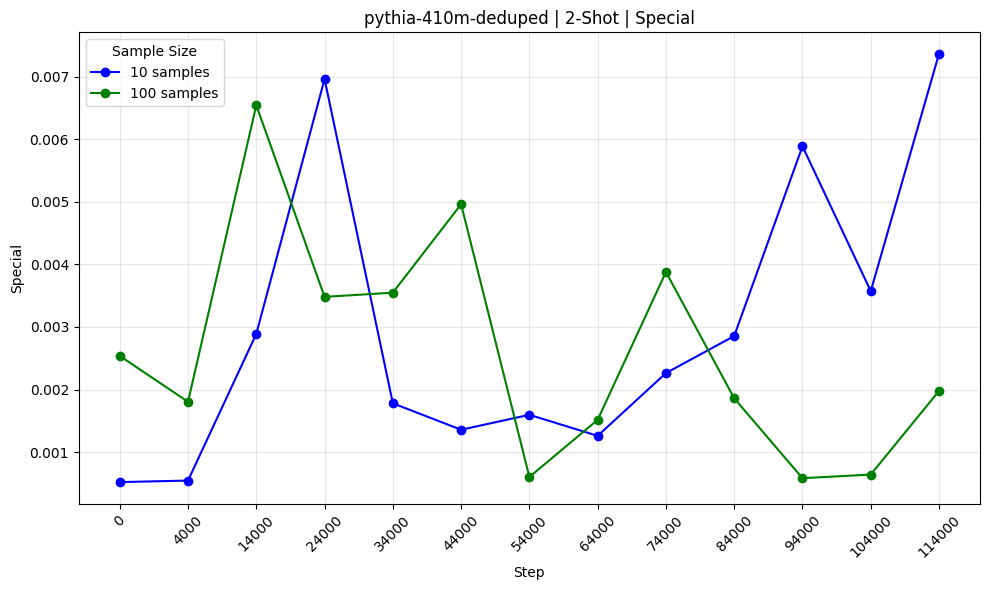

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_special.png


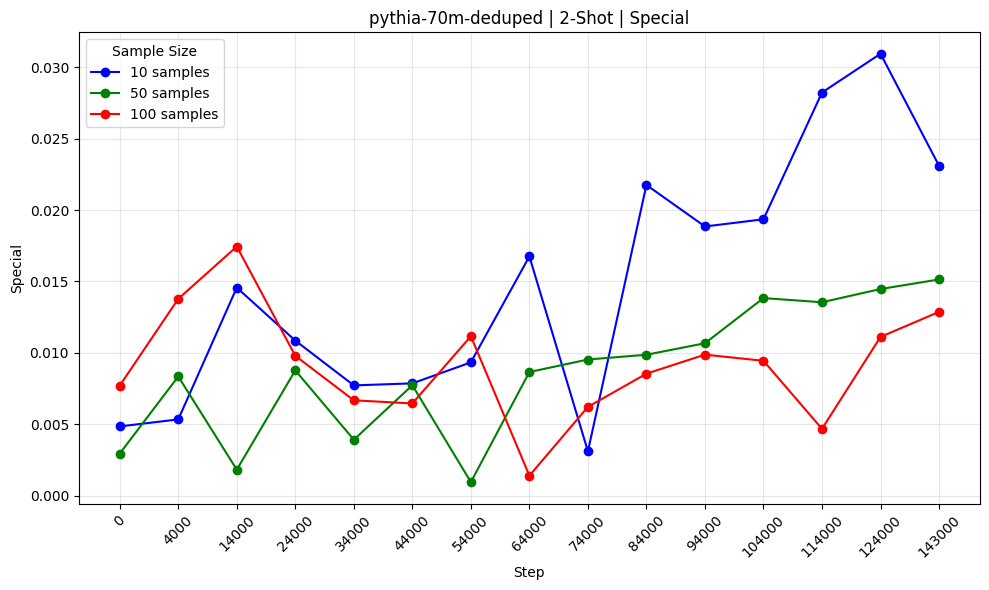

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_special.png


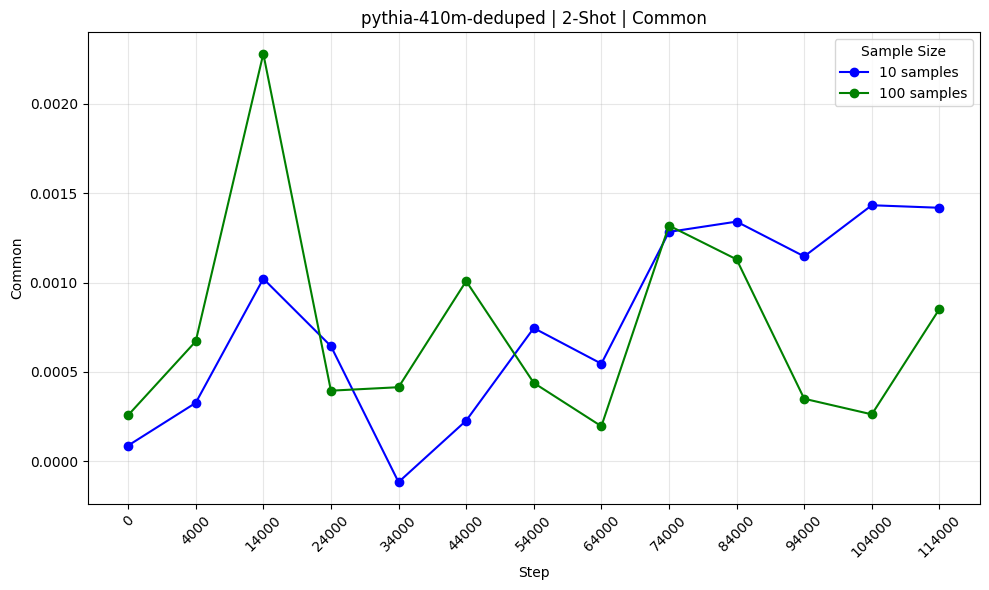

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_common.png


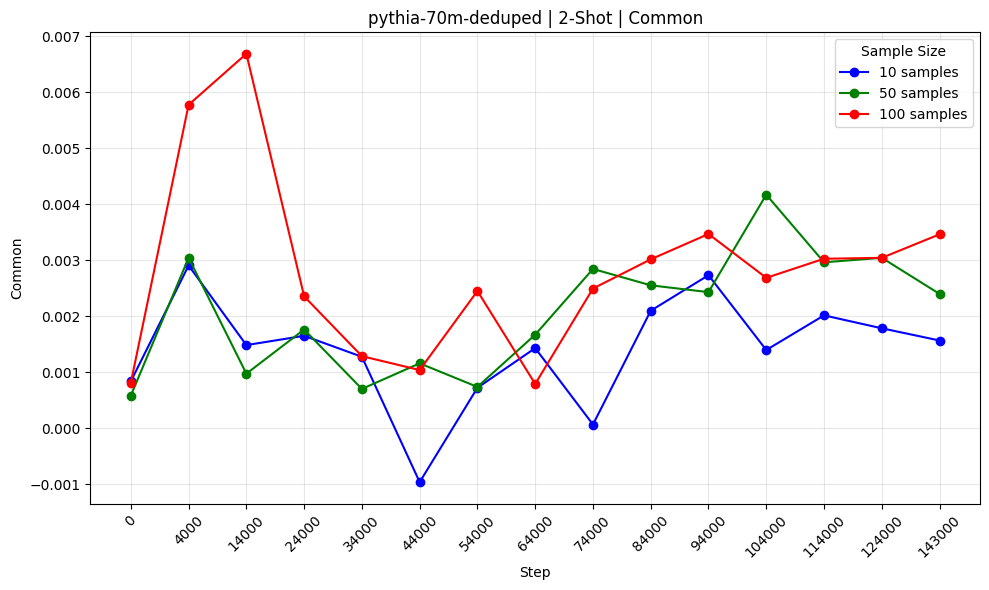

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_common.png


In [10]:
# loop over differento conditions
DATA_DIR = ROOT_dir/'results/classify'
out_dir= ROOT_dir/'fig/geometry/reflection'
model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"]
step_lst = [0,4000,14000,24000,34000,44000,54000,64000,74000,84000,94000,104000,114000,124000,143000]
sample_size_lst = [10, 50, 100]
class_num_lst = [2]
group_type_lst = ["individual"]
filename = "ref_svm_linear_extreme.json"
metric_lst = ["special","common"]

run_pipeline (DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)

/Users/jliu/workspace/RAG/results/classify/pythia-70m-deduped/prob/94000/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/50/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/50/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/50/2/individual

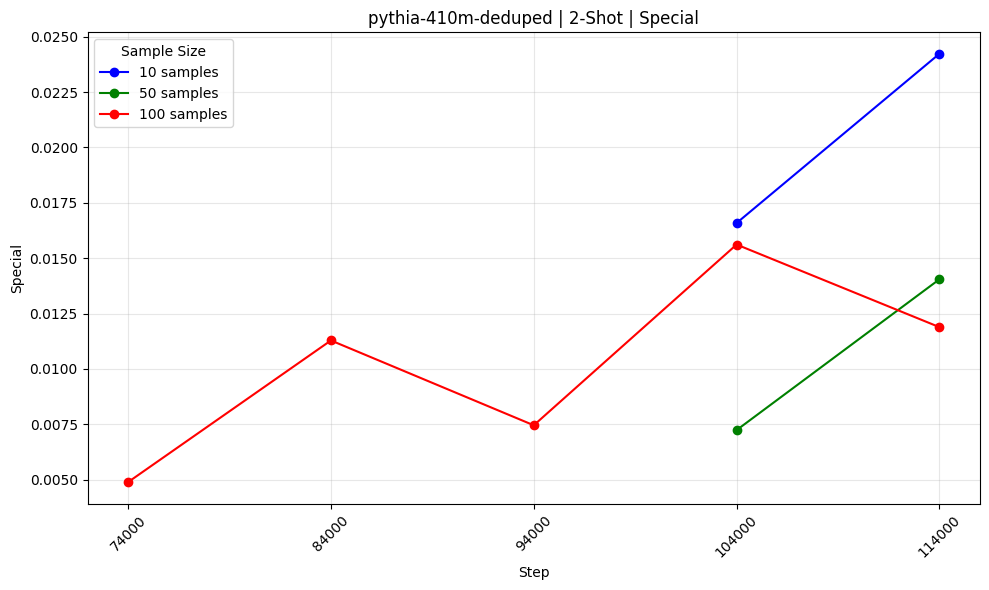

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_special.png


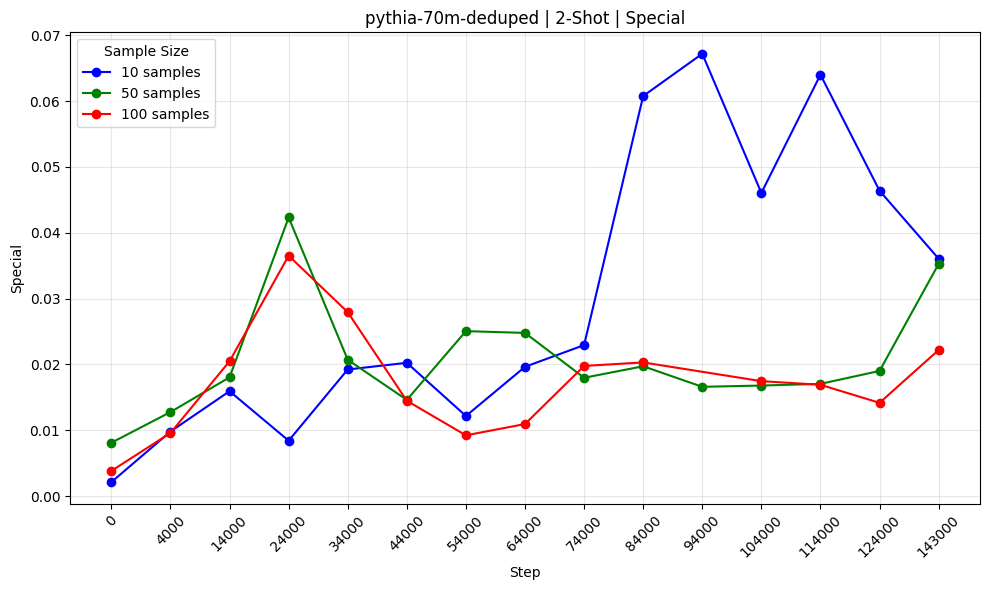

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_special.png


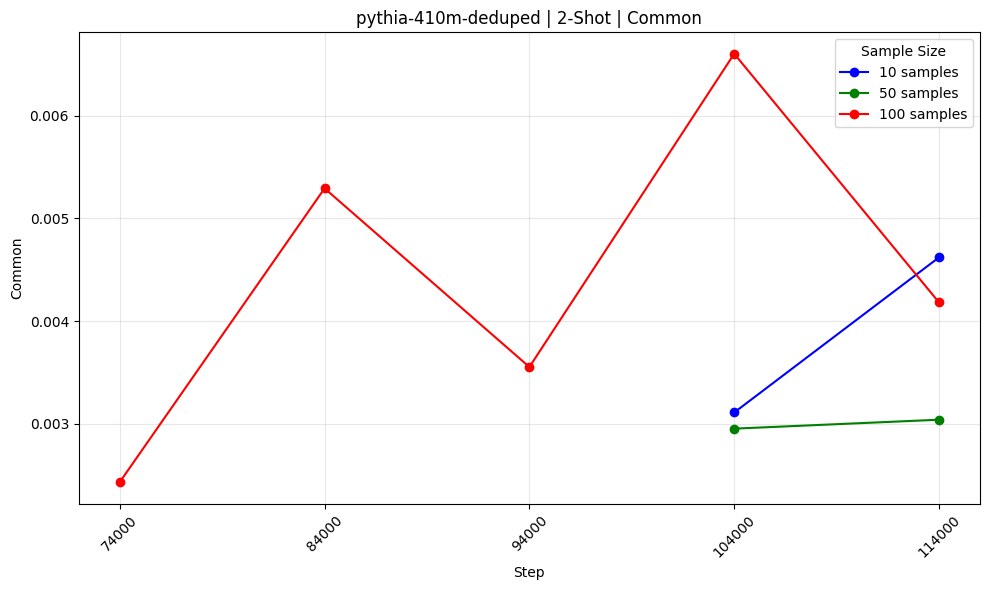

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_common.png


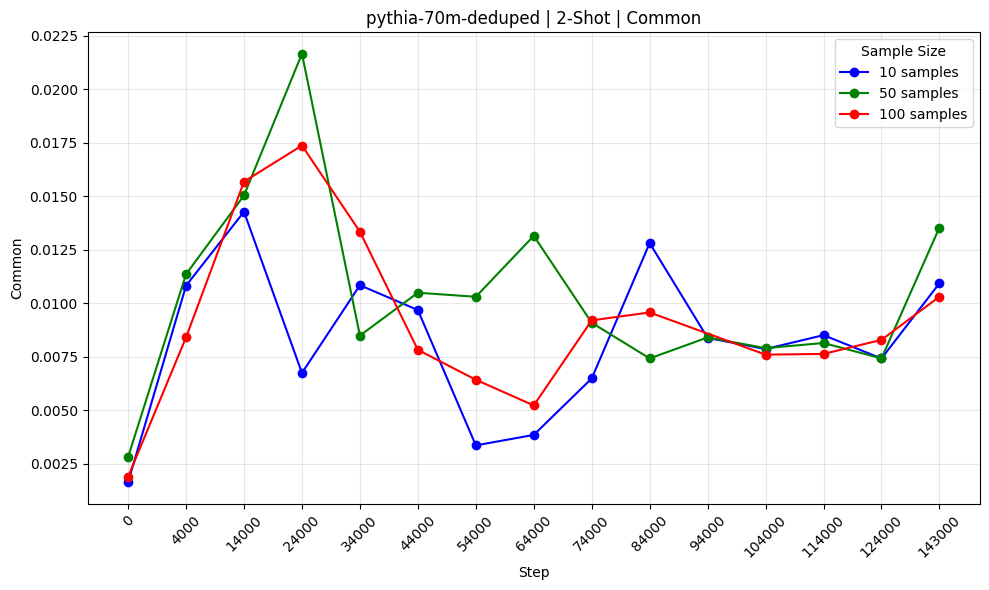

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_common.png


In [7]:
# loop over differento conditions
DATA_DIR = ROOT_dir/'results/classify'
out_dir= ROOT_dir/'fig/geometry/reflection'
model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"]
step_lst = [0,4000,14000,24000,34000,44000,54000,64000,74000,84000,94000,104000,114000,124000,143000]
sample_size_lst = [10, 50, 100]
class_num_lst = [2]
group_type_lst = ["individual"]
filename = "reflection_stat.json"
metric_lst = ["special","common"]

run_pipeline (DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)

示例文件树结构：/Users/curiostudio/Desktop/llm_final/classify_updated
└── EleutherAI
    ├── pythia-410m-deduped
    │   └── prob
    │       ├── 0
    │       │   └── 500
    │       │       └── 100
    │       │           └── 2
    │       │               └── individual
    │       │                   ├── classification_baseline.json
    │       │                   └── separation_analysis_baseline.json
    │       ├── 104000
    │       │   └── 500
    │       │       ├── 10
    │       │       │   ├── 2
    │       │       │   │   └── individual
    │       │       │   │       ├── classification_baseline.json
    │       │       │   │       ├── classification.json
    │       │       │   │       ├── separation_analysis_baseline.json
    │       │       │   │       └── separation_analysis.json
    │       │       │   └── 3
    │       │       │       └── individual
    │       │       │           ├── classification.json
    │       │       │           └── separation_analysis.json
    │       │       ├── 100

！！！注意：这部分代码是专门处理htsr数据的（见for f in root.rglob('htsr/**/prob/*.json'):—），所以如果是混合上面部分的geometry，也可以直接把母文件路径给它自动跳过不相关数据

In [1]:
##classify-htsr

import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# —— 原有映射，保持不变 —— 
SETTING_MAP = {"group_best":"gbest","group_target_size":"gtsize","individual":"indiv"}
MODEL_MAP   = {"pythia-70m-deduped":"70m","pythia-410m-deduped":"410m"}

NEURONS    = [10,50,100]           # 对应文件 500_10.json, 500_50.json, 500_100.json
COLORS     = ['blue','green','red']
CASE_LIST  = ["boost","suppress","random_1"]
CASE_STYLE = {
    "boost":    {"marker":"o","linestyle":"-"},
    "suppress": {"marker":"s","linestyle":"--"},
    "random_1": {"marker":"^","linestyle":":"},
}

# —— 我们的新指标配置 —— 
STAT_CONFIGS = [
    {"name":"ESD Spike Separation","section":"esd_shape","subsection":None,
     "key":"spike_separation","yrange":None},
    {"name":"PL Alpha Hill (↓ heavier tail)","section":"shape_metrics","subsection":None,
     "key":"pl_alpha_hill","yrange":None},
    {"name":"Phase Structured Indicator","section":"phase_transition","subsection":None,
     "key":"phase_metric","yrange":(-2.1,0.5)},
    {"name":"Bulk–Spike Interaction Strength","section":"bulk_spike_interaction","subsection":None,
     "key":"interaction_strength","yrange":None},
]

CMP_CONFIGS = [
    {"name":"Alpha Hill: Boost vs Common","key":"alpha_hill_boost_vs_common"},
    {"name":"Alpha Hill: Suppress vs Common","key":"alpha_hill_suppress_vs_common"},
    {"name":"Alpha Hill: Suppress vs Boost","key":"alpha_hill_suppress_vs_boost"},
    {"name":"Stable Rank: Boost vs Common","key":"stable_rank_boost_vs_common"},
    {"name":"Stable Rank: Suppress vs Common","key":"stable_rank_suppress_vs_common"},
    {"name":"Stable Rank: Suppress vs Boost","key":"stable_rank_suppress_vs_boost"},
    {"name":"Entropy: Boost vs Common","key":"entropy_boost_vs_common"},
    {"name":"Entropy: Suppress vs Common","key":"entropy_suppress_vs_common"},
    {"name":"Entropy: Suppress vs Boost","key":"entropy_suppress_vs_boost"},
]

def slugify(text):
    return re.sub(r'\W+','_', text).strip('_').lower()

def load_all_json(root_dir):
    root = Path(root_dir)
    recs = []
    for f in root.rglob('htsr/**/prob/*.json'):
        parts = list(f.relative_to(root).parts)
        # 去掉末尾的 'prob' 与文件名
        dir_parts = parts[:-2]
        recs.append({
            'dir_parts': dir_parts,
            'filename': f.name,
            'data': json.loads(f.read_text(encoding='utf-8'))
        })
    return recs

def plot_combined(root_dir, out_dir):
    recs = load_all_json(root_dir)

    # 按所在文件夹分组
    groups = {}
    for r in recs:
        key = tuple(r['dir_parts'])
        groups.setdefault(key, []).append(r)

    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    ncols = 2
    nrows = (len(STAT_CONFIGS)+1)//2

    for dir_parts, files in groups.items():
        # 生成图标题
        title_parts = [SETTING_MAP.get(p, MODEL_MAP.get(p, p)) for p in dir_parts]
        suptitle = " | ".join(title_parts)

        # 收集不同 size（10/50/100）对应的数据
        data_dict = {}
        for r in files:
            m = re.match(r'500_(\d+)\.json', r['filename'])
            if m:
                size = int(m.group(1))
                data_dict[size] = r['data']
        if not data_dict:
            continue

        # —— 第一张：四个指标折线图 —— 
        fig, axes = plt.subplots(nrows, ncols,
                                 figsize=(ncols*6, nrows*4),
                                 squeeze=False)
        axes = axes.flatten()

        for ax, stat in zip(axes, STAT_CONFIGS):
            any_curve = False

            for i, nn in enumerate(NEURONS):
                data = data_dict.get(nn)
                if data is None:
                    continue

                # x 轴：样本 ID，为了可视化我们用排序后的整数 ID
                steps = sorted(int(k) for k in data.keys())
                x = steps

                for case in CASE_LIST:
                    y = []
                    for s in steps:
                        entry = data[str(s)].get(case, {})
                        # 对 phase 字段单独处理
                        if stat["key"] == "phase":
                            phase = entry.get("phase_transition",{}).get("phase")
                            v = 1.0 if phase == "structured" else 0.0
                        else:
                            v = entry.get(stat["section"],{}).get(stat["key"])
                        y.append(np.nan if v is None else v)

                    if all(np.isnan(y)):
                        continue

                    style = CASE_STYLE[case]
                    ax.plot(x, y,
                            color=COLORS[i],
                            marker=style["marker"],
                            linestyle=style["linestyle"],
                            label=f"{case} {nn}")
                    any_curve = True

            if not any_curve:
                ax.text(0.5,0.5,"No data", ha='center', va='center', alpha=0.3)

            ax.set_title(stat["name"])
            ax.set_xlabel("Sample ID")
            ax.set_ylabel(stat["name"])
            
            if stat["yrange"]:
                ax.set_ylim(*stat["yrange"])
            ax.grid(alpha=0.3)
            ax.legend(title="# Samples / Case", fontsize='small')

        fig.suptitle(suptitle, fontsize=14)
        fig.tight_layout(rect=[0,0,1,0.95])
        fname1 = out / f"{slugify(suptitle)}_metrics.png"
        fig.savefig(fname1, dpi=200)
        plt.close(fig)
        print(f"Saved {fname1}")

        # —— 第二张：三项跨组比较 —— 
        fig2, axes2 = plt.subplots(1, len(CMP_CONFIGS),
                                   figsize=(len(CMP_CONFIGS)*5, 4),
                                   squeeze=False)
        axes2 = axes2.flatten()

        for ax, cmp_stat in zip(axes2, CMP_CONFIGS):
            any_curve = False

            for i, nn in enumerate(NEURONS):
                data = data_dict.get(nn)
                if data is None:
                    continue

                steps = sorted(int(k) for k in data.keys())
                x = steps
                y = []
                for s in steps:
                    comp = data[str(s)].get("comparisons", {})
                    # 根据 key 前缀选择所属子模块
                    if cmp_stat["key"].startswith("alpha_hill"):
                        v = comp.get("shape_metrics",{}).get(cmp_stat["key"])
                    elif cmp_stat["key"].startswith("spike"):
                        v = comp.get("esd_shape",{}).get(cmp_stat["key"])
                    else:
                        v = comp.get("bulk_spike_interaction",{}).get(cmp_stat["key"])
                    y.append(np.nan if v is None else v)

                if all(np.isnan(y)):
                    continue

                # 直接重用 CASE_STYLE 里的 marker/linestyle，也可以定义新的 CMP_STYLE
                style = CASE_STYLE.get(cmp_stat["key"].split("_")[0], {"marker":"o","linestyle":"-"})
                ax.plot(x, y,
                        color=COLORS[i],
                        marker=style["marker"],
                        linestyle=style["linestyle"],
                        label=str(nn))
                any_curve = True

            if not any_curve:
                ax.text(0.5,0.5,"No data", ha='center', va='center', alpha=0.3)

            ax.set_title(cmp_stat["name"])
            ax.set_xlabel("Sample ID")
            ax.set_ylabel("Δ Value")
            ax.grid(alpha=0.3)
            ax.legend(title="# Samples", fontsize='small')

        fig2.suptitle(suptitle + " — Comparisons", fontsize=14)
        fig2.tight_layout(rect=[0,0,1,0.93])
        fname2 = out / f"{slugify(suptitle)}_comparisons.png"
        fig2.savefig(fname2, dpi=200)
        plt.close(fig2)
        print(f"Saved {fname2}")

# —— 示例调用 —— 
if __name__ == '__main__':
    plot_combined(
        root_dir='/Users/jliu/workspace/RAG/results/geometry',
        out_dir='/Users/jliu/workspace/RAG/fig/geometry/htsr'
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_410m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_410m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_410m_comparisons.png


## our assumption: 
special: reduced delta loss after reflection 
-> negative for the comparison


common: increased delta loss 
-> positive for the comparison 